In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

### all results

S-ICL sst2
{'Logistic Regression': [0.68671875, 0.821875, 0.86640625, 0.88046875, 0.88203125, 0.8890625, 0.90546875, 0.89921875, 0.89140625]}
{'Logistic Regression': [0.06550398067579558, 0.0690865342794817, 0.07804683589838861, 0.045771516670100085, 0.018405029670921478, 0.00810017240364364, 0.011848242881330547, 0.015477822465749178, 0.01777236432199582]}
S-ICL subj
{'Logistic Regression': [0.8328125, 0.85390625, 0.890625, 0.90078125, 0.9046875, 0.92109375, 0.915625, 0.92421875, 0.921875]}
{'Logistic Regression': [0.04344550847937276, 0.046597485807645785, 0.022777155839239456, 0.02185406364171776, 0.016937096397405312, 0.009326044051807283, 0.016710351278287062, 0.013699748372461079, 0.010334966058846057]}
S-ICL mpqa
{'Logistic Regression': [0.615625, 0.73984375, 0.7921875, 0.8140625, 0.8359375, 0.8484375, 0.8421875, 0.84765625, 0.82734375]}
{'Logistic Regression': [0.08316735586773967, 0.024331892972495994, 0.017337766422790737, 0.030458732327528014, 0.014874556847390447, 0.0121659

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\1890623993.py:160: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


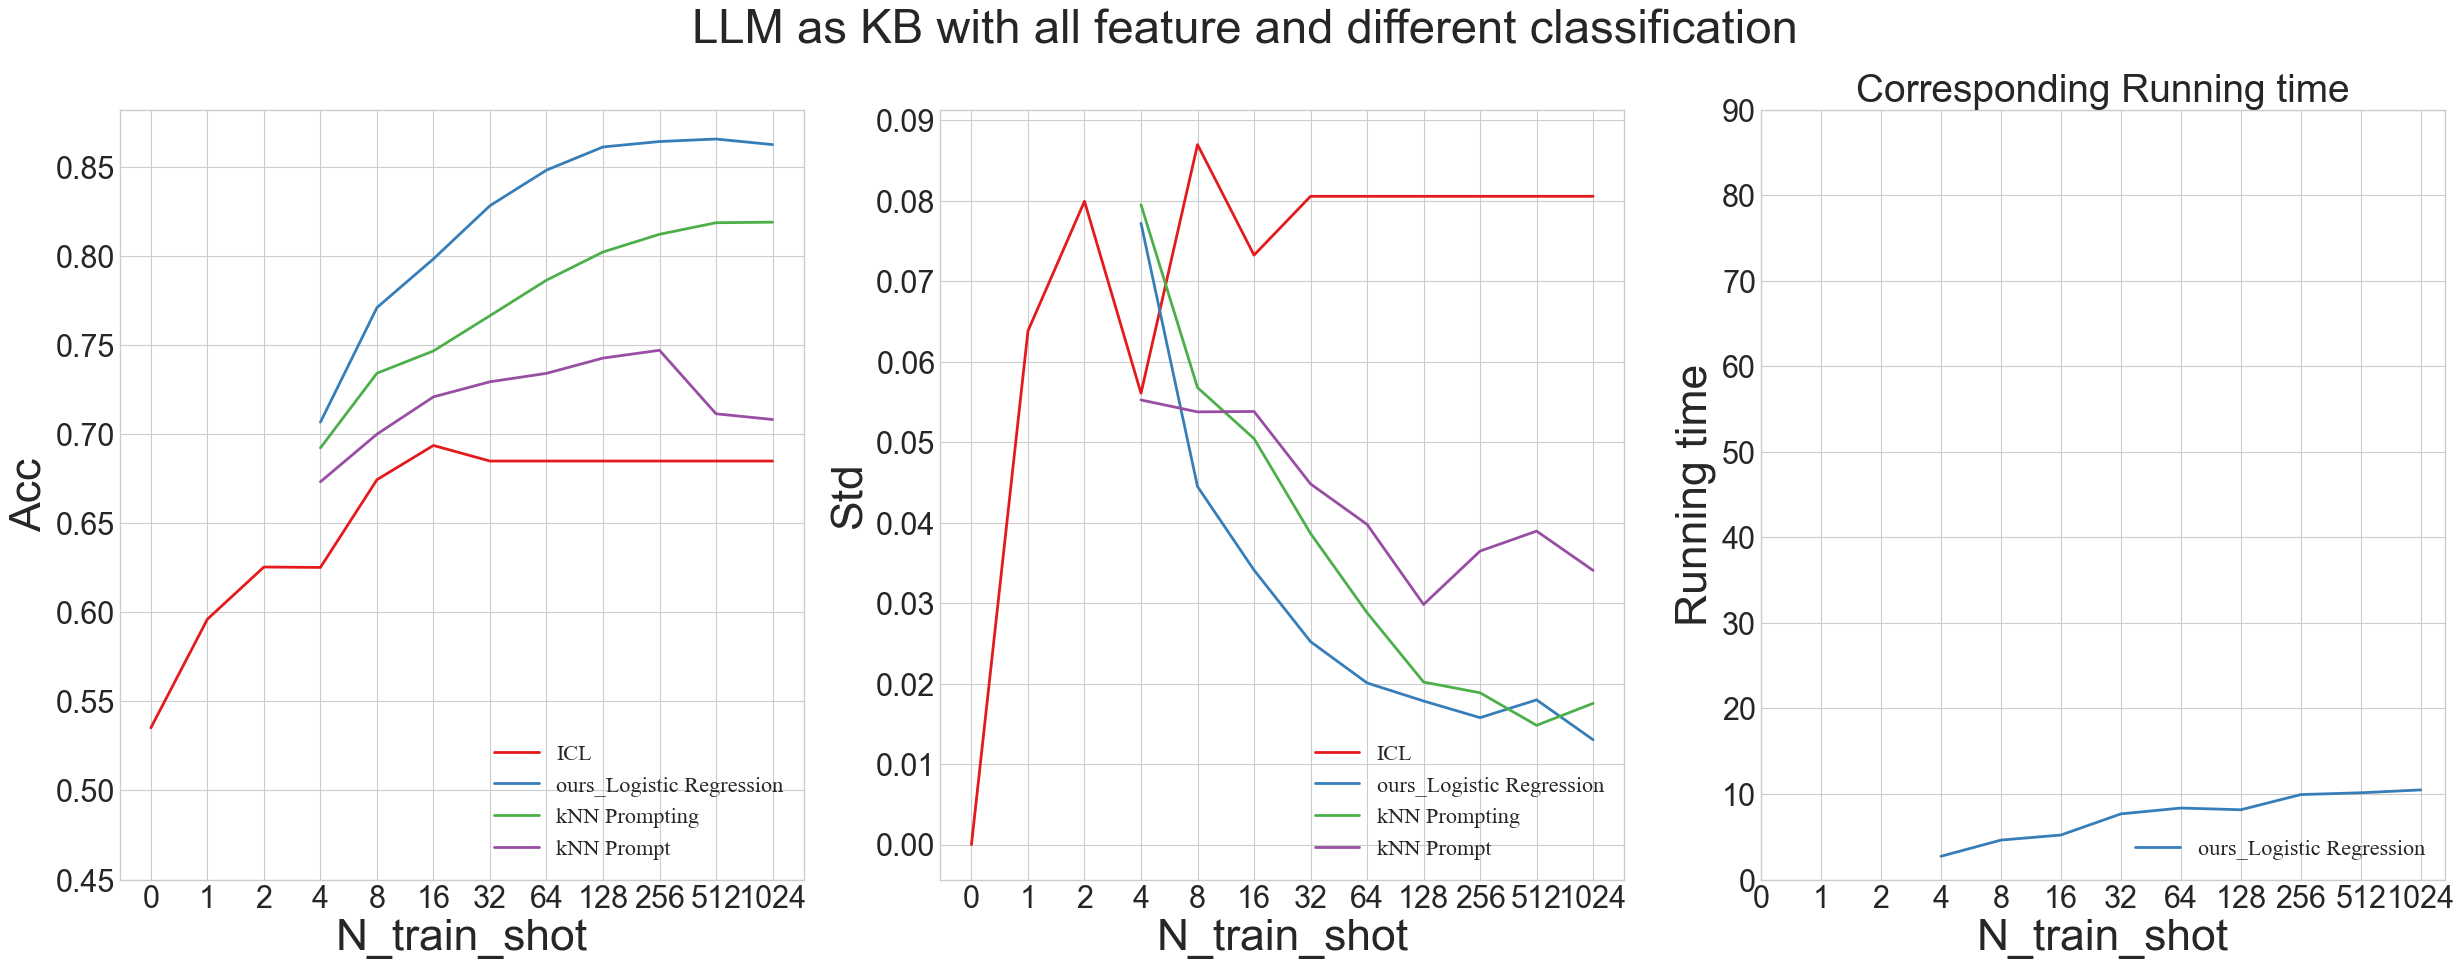

In [98]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
method_set = ['Logistic Regression'] #'MLP', 
# KB results 
result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
std_dicts = []
avg_running_time = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    running_time_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        running_time_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
            choosed_running_time = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['running_time']
            running_time_dict[method].append(choosed_running_time.mean())
    avg_dicts.append(avg_dict)
    std_dicts.append(std_dict)
    print("FADS-ICL", dataset)
    print(avg_dict)
    print(std_dict)
    avg_running_time.append(running_time_dict)
for i, shot in enumerate(fuzzy_label_shots):
    print(shot)
    _avg_list = [_avg_dict[method_set[0]][i] for _avg_dict in avg_dicts]
    _std_list = [_std_dict[method_set[0]][i] for _std_dict in std_dicts]
    _ele_list = [str(round(_avg * 100, 1)) + r"$_{\pm\textrm" + str(round(_std * 100, 1)) + r"}$" for _avg, _std in zip(_avg_list, _std_list)]
    output_str = "&".join(_ele_list)
    print(output_str)


# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()
    print(icl_n_train_shot_set)

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())
        # print(choosed_acc)
    
    print("ICL", DATASETS[index])
    print(icl_avg)
    print(icl_std)
    # break

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)


# KNN results
knn_results = '../output/results_knnprompting.csv'
knn_dfs = pd.read_csv(knn_results)

knn_avgs = []
knn_stds = []
for index, dataset in enumerate(DATASETS):
    knn_df = knn_dfs[knn_dfs['dataset'] == dataset]

    knn_avg = []
    knn_std = []
    for n_train_shot in knn_train_shots:
        choosed_acc = knn_df[knn_df['n_train_shot'] == n_train_shot]['acc']
        knn_avg.append(choosed_acc.mean())
        knn_std.append(choosed_acc.std())

    knn_avgs.append(knn_avg)
    knn_stds.append(knn_std)

print("knn-prompting")
for i, shot in enumerate(knn_train_shots):
    print(shot)
    _avg_list = [_avg_dict[i] for _avg_dict in knn_avgs]
    _std_list = [_std_dict[i] for _std_dict in knn_stds]
    _ele_list = [str(round(_avg * 100, 1)) + r"$_{\pm\textrm" + str(round(_std * 100, 1)) + r"}$" for _avg, _std in zip(_avg_list, _std_list)]
    output_str = "&".join(_ele_list)
    print(output_str)

# knn-prompt results
prompt_results = f'../output/knn-prompt/{MODEL}/results_knnprompt.csv'
prompt_dfs = pd.read_csv(prompt_results)

prompt_avgs = []
prompt_stds = []
for index, dataset in enumerate(DATASETS):
    prompt_df = prompt_dfs[prompt_dfs['dataset'] == dataset]

    prompt_avg = []
    prompt_std = []
    for n_train_shot in knn_train_shots:
        choosed_acc = prompt_df[prompt_df['n_train_shot'] == n_train_shot]['acc']
        prompt_avg.append(choosed_acc.mean())
        prompt_std.append(choosed_acc.std())

    prompt_avgs.append(prompt_avg)
    prompt_stds.append(prompt_std)

print("knn-prompt")
for i, shot in enumerate(knn_train_shots):
    print(shot)
    _avg_list = [_avg_dict[i] for _avg_dict in prompt_avgs]
    _std_list = [_std_dict[i] for _std_dict in prompt_stds]
    _ele_list = [str(round(_avg * 100, 1)) + r"$_{\pm\textrm" + str(round(_std * 100, 1)) + r"}$" for _avg, _std in zip(_avg_list, _std_list)]
    output_str = "&".join(_ele_list)
    print(output_str)

# # KNN-demo1 results
# knn_demo1_results = '../output/knn_demo1/results_knnprompting.csv'
# knn_demo1_dfs = pd.read_csv(knn_demo1_results)

# knn_demo1_avgs = []
# knn_demo1_stds = []
# for index, dataset in enumerate(DATASETS):
#     knn_demo1_df = knn_demo1_dfs[knn_demo1_dfs['dataset'] == dataset]

#     knn_avg = []
#     knn_std = []
#     for n_train_shot in fuzzy_label_shots:
#         choosed_acc = knn_demo1_df[knn_demo1_df['n_train_shot'] == n_train_shot]['acc']
#         knn_avg.append(choosed_acc.mean())
#         knn_std.append(choosed_acc.std())

#     knn_demo1_avgs.append(knn_avg)
#     knn_demo1_stds.append(knn_std)

plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}
std_dict = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts]) for method in method_set}
running_time_dict = {method: avg_on_dataset([_timedict[method] for _timedict in avg_running_time]) for method in method_set}
icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)
def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours_{name_of_alg}' if not is_icl else name_of_alg,linewidth=4)

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)
print("avg acc")
print(icl_avg)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method])
    print(avg_dict[method])

knn_avg = avg_on_dataset(knn_avgs)
knn_std = avg_on_dataset(knn_stds)
color=palette(len(method_set) + 1)
plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_avg, color=color,label='kNN Prompting',linewidth=4)
print(knn_avg)

prompt_avg = avg_on_dataset(prompt_avgs)
prompt_std = avg_on_dataset(prompt_stds)
color=palette(len(method_set) + 2)
plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], prompt_avg, color=color,label='kNN Prompt',linewidth=4)
print(prompt_avg)

# knn_demo1_avg = avg_on_dataset(knn_demo1_avgs)
# knn_demo1_std = avg_on_dataset(knn_demo1_stds)
# color=palette(len(method_set) + 2)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_demo1_avg, color=color,label='KNN_demo1',linewidth=4)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

print("avg std ")
plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
print(icl_std)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, std_dict[method])
    print(std_dict[method])
color=palette(len(method_set) + 1)
plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_std, color=color,label='kNN Prompting',linewidth=4)
print(knn_std)
color=palette(len(method_set) + 2)
plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], prompt_std, color=color,label='kNN Prompt',linewidth=4)
print(prompt_std)
# color=palette(len(method_set) + 2)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_demo1_std, color=color,label='KNN_demo1',linewidth=4)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)

plt.subplot(1, 3, 3)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, running_time_dict[method])

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=100,step=10), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Running time',fontsize=32)
plt.legend(loc='lower right',prop=font1)
plt.title(f"Corresponding Running time", fontsize=28)

plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()

### demo or not?

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\3680478922.py:117: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


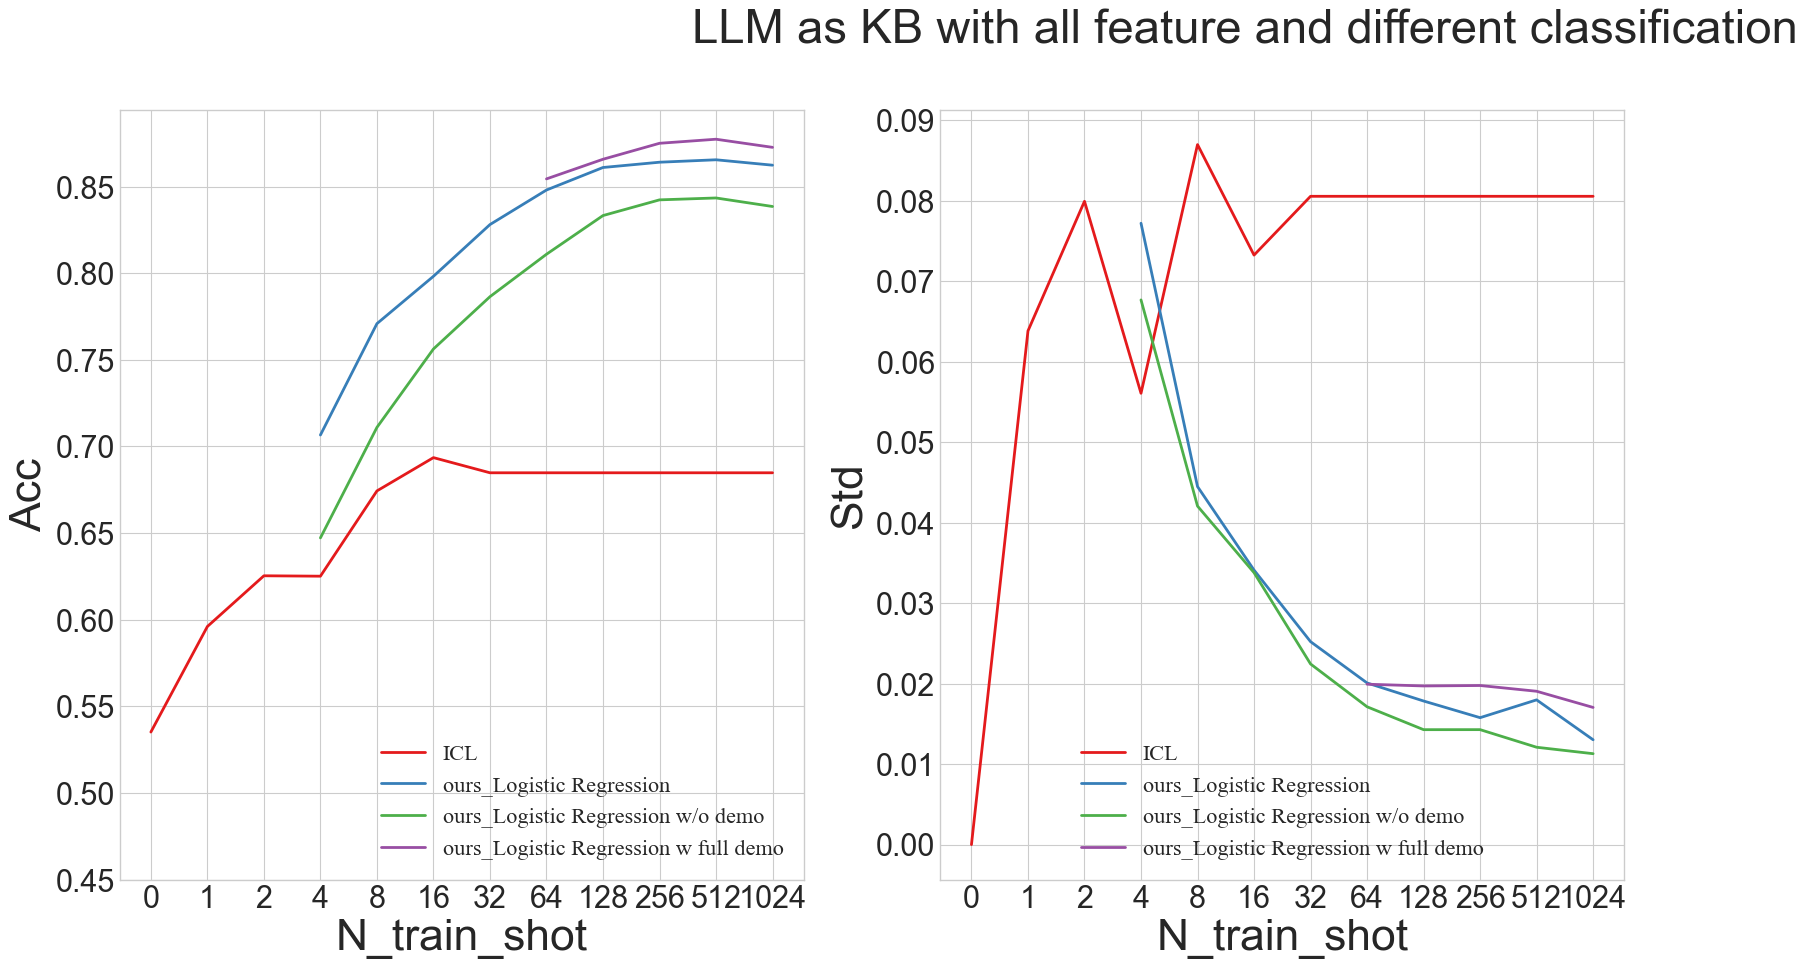

In [28]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
method_set = ['Logistic Regression', ] # 'MLP', 'Logistic Regression'
# KB results
result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
std_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
    avg_dicts.append(avg_dict)
    std_dicts.append(std_dict)

# KB without demo results
result_demo0 = f'../output/hs_as_feature/{MODEL}/results_hs_as_feature.csv'
result_dfs_demo0 = pd.read_csv(result_demo0)


avg_dicts_demo0 = []
std_dicts_demo0 = []
for dataset in DATASETS:
    df_demo0 = result_dfs_demo0[result_dfs_demo0['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df_demo0['n_train_shot'].unique().tolist()
    seed_set = df_demo0['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df_demo0[(df_demo0['method'] == method) & (df_demo0['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())

    avg_dicts_demo0.append(avg_dict)
    std_dicts_demo0.append(std_dict)

# KB with demo=most results
result_demo0 = f'../output/hs_as_feature_with_demo_all/{MODEL}/results_hs_as_feature.csv'
result_dfs_demoall = pd.read_csv(result_demo0)


avg_dicts_demoall = []
std_dicts_demoall = []
n_train_shot_set_demoall = [64, 128, 256, 512, 1024]
for dataset in DATASETS:
    df_demoall = result_dfs_demoall[result_dfs_demoall['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    # n_train_shot_set = df_demoall['n_train_shot'].unique().tolist()
    seed_set = df_demoall['seed'].unique().tolist()

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set_demoall:
            choosed_acc = df_demoall[(df_demoall['method'] == method) & (df_demoall['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())

    avg_dicts_demoall.append(avg_dict)
    std_dicts_demoall.append(std_dict)

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)



plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}
std_dict = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts]) for method in method_set}

avg_dict_demo0 = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_demo0]) for method in method_set}
std_dict_demo0 = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_demo0]) for method in method_set}

avg_dict_demoall = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_demoall]) for method in method_set}
std_dict_demoall = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_demoall]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)


def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours_{name_of_alg}' if not is_icl else name_of_alg,linewidth=4)

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method])
for i, method in enumerate(method_set, start=1):
    draw_line(method + ' w/o demo',i + len(method_set), avg_dict_demo0[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = n_train_shot_set_demoall
    color=palette(i + len(method_set)*2)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg_dict_demoall[method], color=color,label='ours_'+method + ' w full demo',linewidth=4)



plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, std_dict[method])
for i, method in enumerate(method_set, start=1):
    draw_line(method + ' w/o demo',i + len(method_set), std_dict_demo0[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = n_train_shot_set_demoall
    color=palette(i + len(method_set)*2)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], std_dict_demoall[method], color=color,label='ours_'+method + ' w full demo',linewidth=4)


plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower center',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)



plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_9480\2731774114.py:151: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


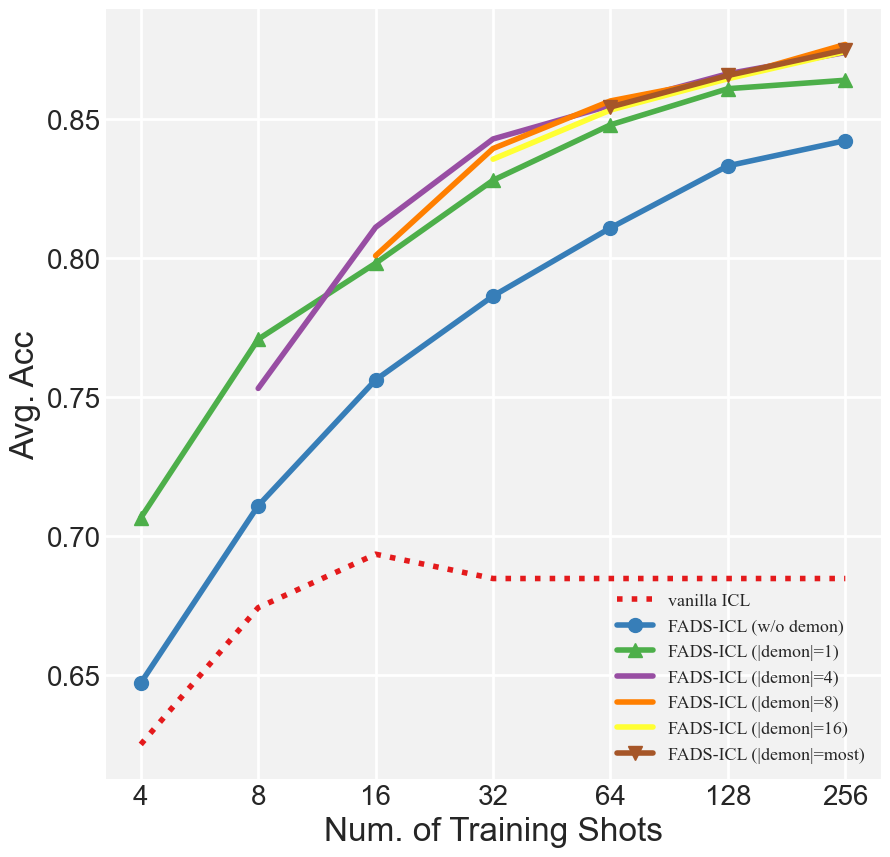

In [12]:



# fig=plt.figure(figsize=(10,10))

# def avg_on_dataset(metrics_list):
#     return np.array(metrics_list).mean(axis=0)
# avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}

# icl_avg = avg_on_dataset(icl_avgs)

# def draw_line(name_of_alg, color_index, avg, is_sicl=True):
#     choosed_shots = plot_shots

#     color=palette(color_index)
#     plt.plot([plot_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'FADS-ICL ({name_of_alg})' if is_sicl else name_of_alg,linewidth=4, linestyle = 'dotted' if not is_sicl else None)

# draw_line('vanilla ICL',0, icl_avg[- len(fuzzy_label_shots):], is_sicl=False)

# knn_avg = avg_on_dataset(knn_avgs)
# color=palette(1)
# plt.plot([plot_shots.index(_shot) for _shot in plot_shots], knn_avg, color=color,label='kNN-prompting',linewidth=4, linestyle = 'dotted')

# prompt_avg = avg_on_dataset(prompt_avgs)
# color=palette(2)
# plt.plot([plot_shots.index(_shot) for _shot in plot_shots], prompt_avg, color=color,label='kNN-prompt',linewidth=4, linestyle = 'dotted')

# for i, method in enumerate(method_set, start=3):
#     draw_line(method,i, avg_dict[method])




MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
plot_shots = [4, 8, 16, 32, 64, 128, 256]
method_set = ['Logistic Regression', ] # 'MLP', 'Logistic Regression'
# KB results
result = f'../output/ablation_other_classifiers/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in plot_shots:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
    avg_dicts.append(avg_dict)

# KB without demo results
result_demo0 = f'../output/hs_as_feature/{MODEL}/results_hs_as_feature.csv'
result_dfs_demo0 = pd.read_csv(result_demo0)


avg_dicts_demo0 = []
for dataset in DATASETS:
    df_demo0 = result_dfs_demo0[result_dfs_demo0['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df_demo0['n_train_shot'].unique().tolist()
    seed_set = df_demo0['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in plot_shots:
            choosed_acc = df_demo0[(df_demo0['method'] == method) & (df_demo0['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())

    avg_dicts_demo0.append(avg_dict)

# KB with demo=most results
result_demo0 = f'../output/hs_as_feature_with_demo_all/{MODEL}/results_hs_as_feature.csv'
result_dfs_demoall = pd.read_csv(result_demo0)


avg_dicts_demoall = []
n_train_shot_set_demoall = [64, 128, 256,] # 512, 1024
for dataset in DATASETS:
    df_demoall = result_dfs_demoall[result_dfs_demoall['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    # n_train_shot_set = df_demoall['n_train_shot'].unique().tolist()
    seed_set = df_demoall['seed'].unique().tolist()

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in n_train_shot_set_demoall:
            choosed_acc = df_demoall[(df_demoall['method'] == method) & (df_demoall['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())

    avg_dicts_demoall.append(avg_dict)

# KB with |demo| in middle results
demons = [4,8,16]
avg_dicts_across_demons = []
for i, _d in enumerate(demons):
    result_demo0 = f'../output/hs_as_feature_with_demo/demon{_d}/{MODEL}/results_hs_as_feature.csv'
    result_dfs = pd.read_csv(result_demo0)


    _avg_dicts = []
    _n_train_shot_set = plot_shots[i+1:] # 512, 1024
    for dataset in DATASETS:
        df_demoall = result_dfs[result_dfs['dataset']==dataset]
        # method_set = df['method'].unique().tolist()
        # n_train_shot_set = df_demoall['n_train_shot'].unique().tolist()
        seed_set = df_demoall['seed'].unique().tolist()

        avg_dict = {}
        for method in method_set:
            avg_dict[method] = []
            for n_train_shot in _n_train_shot_set:
                choosed_acc = df_demoall[(df_demoall['method'] == method) & (df_demoall['n_train_shot'] == n_train_shot)]['acc']
                avg_dict[method].append(choosed_acc.mean())

        _avg_dicts.append(avg_dict)
    avg_dicts_across_demons.append(_avg_dicts)

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_avg = icl_avg[all_shots.index(plot_shots[0]): all_shots.index(plot_shots[-1])+1]
    icl_avgs.append(icl_avg)



plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 13,
}

fig=plt.figure(figsize=(10,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}

avg_dict_demo0 = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_demo0]) for method in method_set}

avg_dict_demoall = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_demoall]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)



def draw_line(name_of_alg, color_index, avg, is_sicl=True,**kwargs):
    choosed_shots = plot_shots

    color=palette(color_index)
    plt.plot([plot_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'FADS-ICL ({name_of_alg})' if is_sicl else name_of_alg,linewidth=4, linestyle = 'dotted' if not is_sicl else None, **kwargs)

draw_line('vanilla ICL',0, icl_avg, is_sicl=False)
for i, method in enumerate(method_set, start=1):
    draw_line('w/o demon',i, avg_dict_demo0[method],marker="o", ms=10)
for i, method in enumerate(method_set, start=1):
    draw_line('|demon|=1',i + len(method_set), avg_dict[method], marker="^", ms=10)

avg_dict_middle_demon = [{method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set} for avg_dicts in avg_dicts_across_demons]
for i, _d in enumerate(demons):
    method = method_set[0]
    choosed_shots = plot_shots[i+1:]
    color=palette(i + 1 + len(method_set)*2)
    plt.plot([plot_shots.index(_shot) for _shot in choosed_shots], avg_dict_middle_demon[i][method], color=color,label=f'FADS-ICL (|demon|={_d})',linewidth=4)

for i, method in enumerate(method_set, start=1):
    choosed_shots = n_train_shot_set_demoall
    color=palette(i + len(method_set)*(2 + len(demons)))
    plt.plot([plot_shots.index(_shot) for _shot in choosed_shots], avg_dict_demoall[method], color=color,label='FADS-ICL (|demon|=most)',linewidth=4,marker="v", ms=10)


plt.xticks(range(len(plot_shots)), labels=plot_shots,fontsize=20)
plt.yticks( fontsize=20)
# plt.yticks(np.arange(start=0.45, stop=0.95,step=0.05), fontsize=22)
plt.xlabel('Num. of Training Shots',fontsize=24)
plt.ylabel('Avg. Acc',fontsize=24)
plt.grid(color = 'white', linestyle = '-',linewidth=2)
ax=plt.gca()  #gca:get current axis得到当前轴
ax.patch.set_facecolor("gray")
ax.patch.set_alpha(0.1) 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
plt.legend(loc='lower right',prop=font1,)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.show()


#### demo0 vs demo1 hs distribution

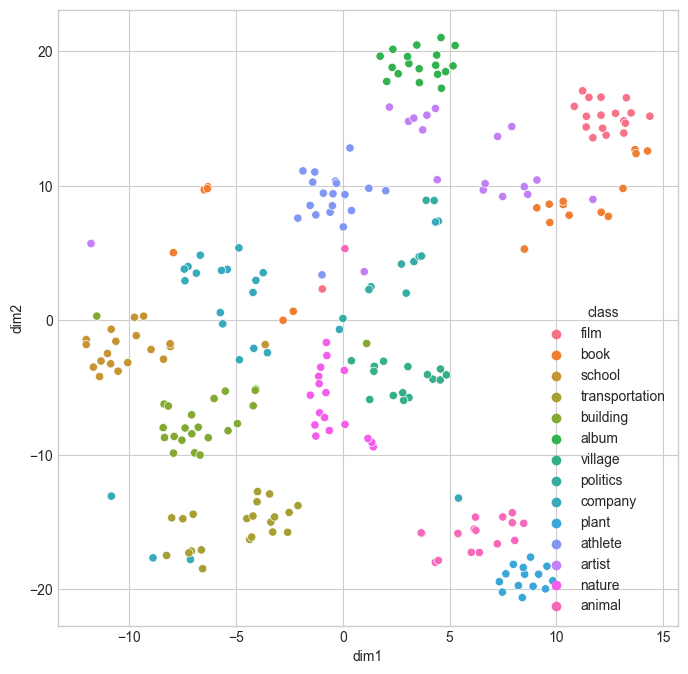

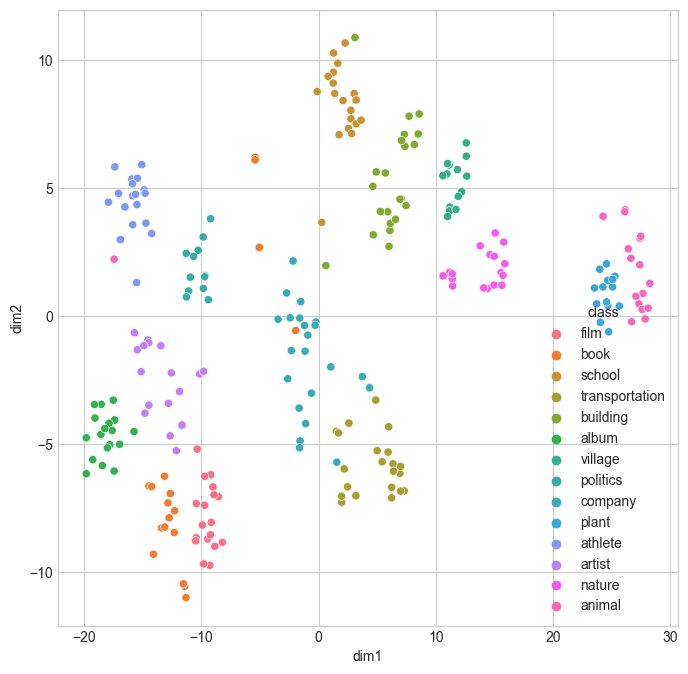

In [33]:
from sklearn.manifold import TSNE 
from sklearn.preprocessing import StandardScaler 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

dataset='dbpedia'
df_demo0 = pd.read_csv(f'{dataset}_demo_0.csv', index_col=0) 
# df_demo0.head()
df_demo1 = pd.read_csv(f'{dataset}_demo_1.csv', index_col=0) 
def plot_tsne(df):
    X=df.iloc[:,:1600]
    Y=df['class']
    tsne = TSNE(n_components=2) 
    X_std = StandardScaler().fit_transform(X) 
    X_tsne = tsne.fit_transform(X_std) 
    X_tsne_data = np.vstack((X_tsne.T, Y)).T 
    df_tsne = pd.DataFrame(X_tsne_data, columns=['dim1', 'dim2', 'class'])
    plt.figure(figsize=(8, 8)) 
    sns.scatterplot(data=df_tsne, hue='class', x='dim1', y='dim2') 
    plt.show()
plot_tsne(df_demo0)
plot_tsne(df_demo1)

#### adaptation w/o clf vs w/ clf

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#e74c3c', '#2ecc71', '#3498db', '#f1c40f'] 14


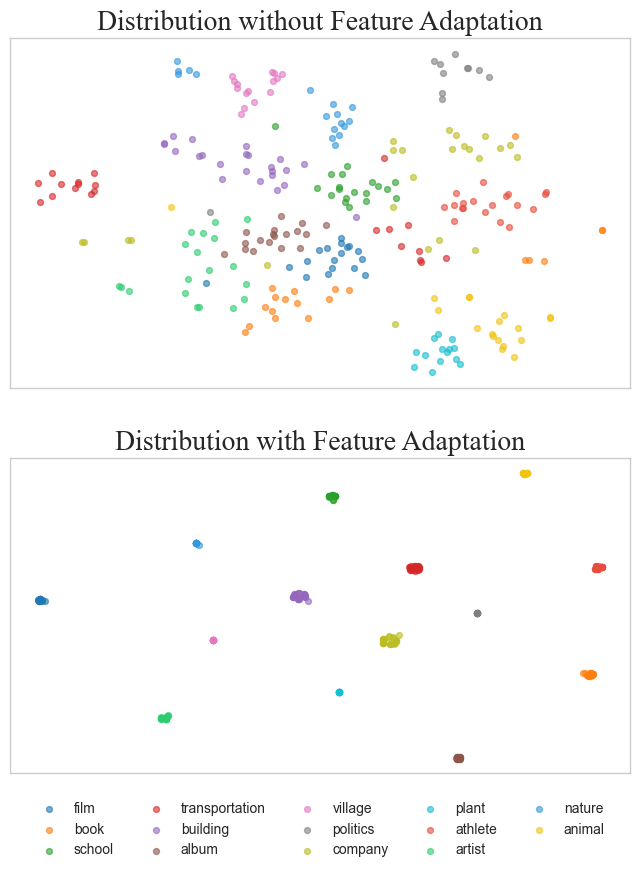

In [23]:
from sklearn.manifold import TSNE 
from sklearn.preprocessing import StandardScaler 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
n_train_shot=128
n_demo_shot=1
dataset='dbpedia'

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
    '#7f7f7f', '#bcbd22', '#17becf', '#e74c3c', '#2ecc71', '#3498db', '#f1c40f'
]
print(colors, len(colors))
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
plt.figure(figsize=(8, 10))
df_wo_clf = pd.read_csv(f'{dataset}_train_{n_train_shot}_demo_{n_demo_shot}_probs.csv', index_col=0) 
class_list = list(df_wo_clf['class'].unique())
df_w_clf = pd.read_csv(f'{dataset}_train_{n_train_shot}_demo_{n_demo_shot}_probs_after_clf.csv', index_col=0)

def plot_tsne(df, title=''):
    n_columns = len(df.columns)
    X=df.iloc[:,:n_columns-1]
    Y=df['class']
    tsne = TSNE(n_components=2, random_state=0) 
    X_std = StandardScaler().fit_transform(X) 
    X_tsne = tsne.fit_transform(X_std) 
    X_tsne_data = np.vstack((X_tsne.T, Y)).T 
    df_tsne = pd.DataFrame(X_tsne_data, columns=['dim1', 'dim2', 'class'])
    # sns.scatterplot(data=df_tsne, hue='class', x='dim1', y='dim2', legend="brief", palette=sns.color_palette("hls", 10)) 
    for label in df_tsne['class'].unique():
        tmp_df = df_tsne[df_tsne['class'] == label]
        plt.scatter(tmp_df['dim1'], tmp_df['dim2'],  label=label, color=colors[class_list.index(label)], \
                    marker="o", alpha=0.6, s= 1/2 * plt.rcParams['lines.markersize'] ** 2) # cmap='gist_rainbow' alpha=0.5 
    plt.title(title, fontdict=font1)
    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    frame.axes.get_xaxis().set_visible(False)
    # plt.legend(loc = (1.1,0.5)) # 'lower right'
    plt.grid(False)
    


plt.subplot(2, 1, 1) 
plot_tsne(df_wo_clf, title='Distribution without Feature Adaptation')

ax = plt.subplot(2, 1, 2) 
plot_tsne(df_w_clf, title='Distribution with Feature Adaptation')
box = ax.get_position()
#将坐标轴的位置上移10%
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# 将图例置于当前坐标轴下
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.legend(loc = 'center right') # 'lower right'
# plt.tight_layout()
plt.savefig('intro.svg', format='svg')
plt.show()


#### surface form competetion

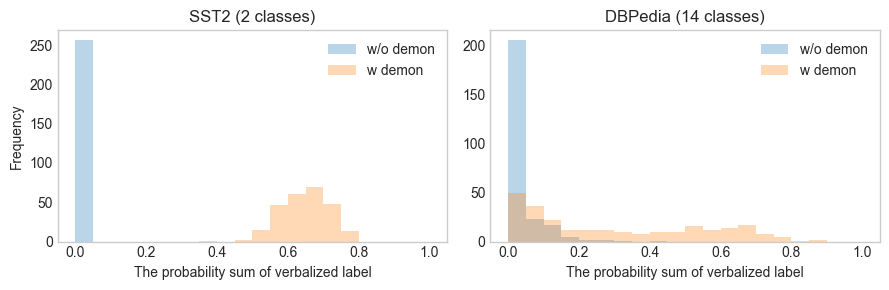

In [16]:
plt.figure(figsize=(9,3))
for i, dataset in enumerate(['sst2', 'dbpedia']):

    ax = plt.subplot(1, 2, i+1) 
    
    data_demo0 = np.load(f"SFC_{dataset}_demo_0.npy").tolist()
    data_demo1 = np.load(f"SFC_{dataset}_demo_1.npy").tolist()
    # 绘制密度分布图
    kwargs = dict(density=False, alpha=0.3, bins=20, range=(0,1))
    plt.hist(data_demo0, **kwargs, label="w/o demon")
    plt.hist(data_demo1, **kwargs, label="w demon")
    plt.legend()
    # plt.hist(data_demo0,density=True , alpha=0.5)

    # 添加标题和轴标签
    if dataset == 'sst2':
        name="SST2"
        classes = 2
    else:
        name="DBPedia"
        classes = 14
    plt.title(f"{name} ({classes} classes)")
    
    plt.xlabel("The probability sum of verbalized label") 
    if i==0:
        plt.ylabel("Frequency")
# plt.legend()
    plt.grid(color = 'white', linestyle = '-',linewidth=2)
# ax=plt.gca()  #gca:get current axis得到当前轴
# ax.patch.set_facecolor("gray")
# ax.patch.set_alpha(0.1) 
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['bottom'].set_color('none')
# 显示图形

plt.tight_layout()
plt.savefig('SFC.svg', format='svg')
plt.show()

### hs vs probs

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\4269007601.py:91: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


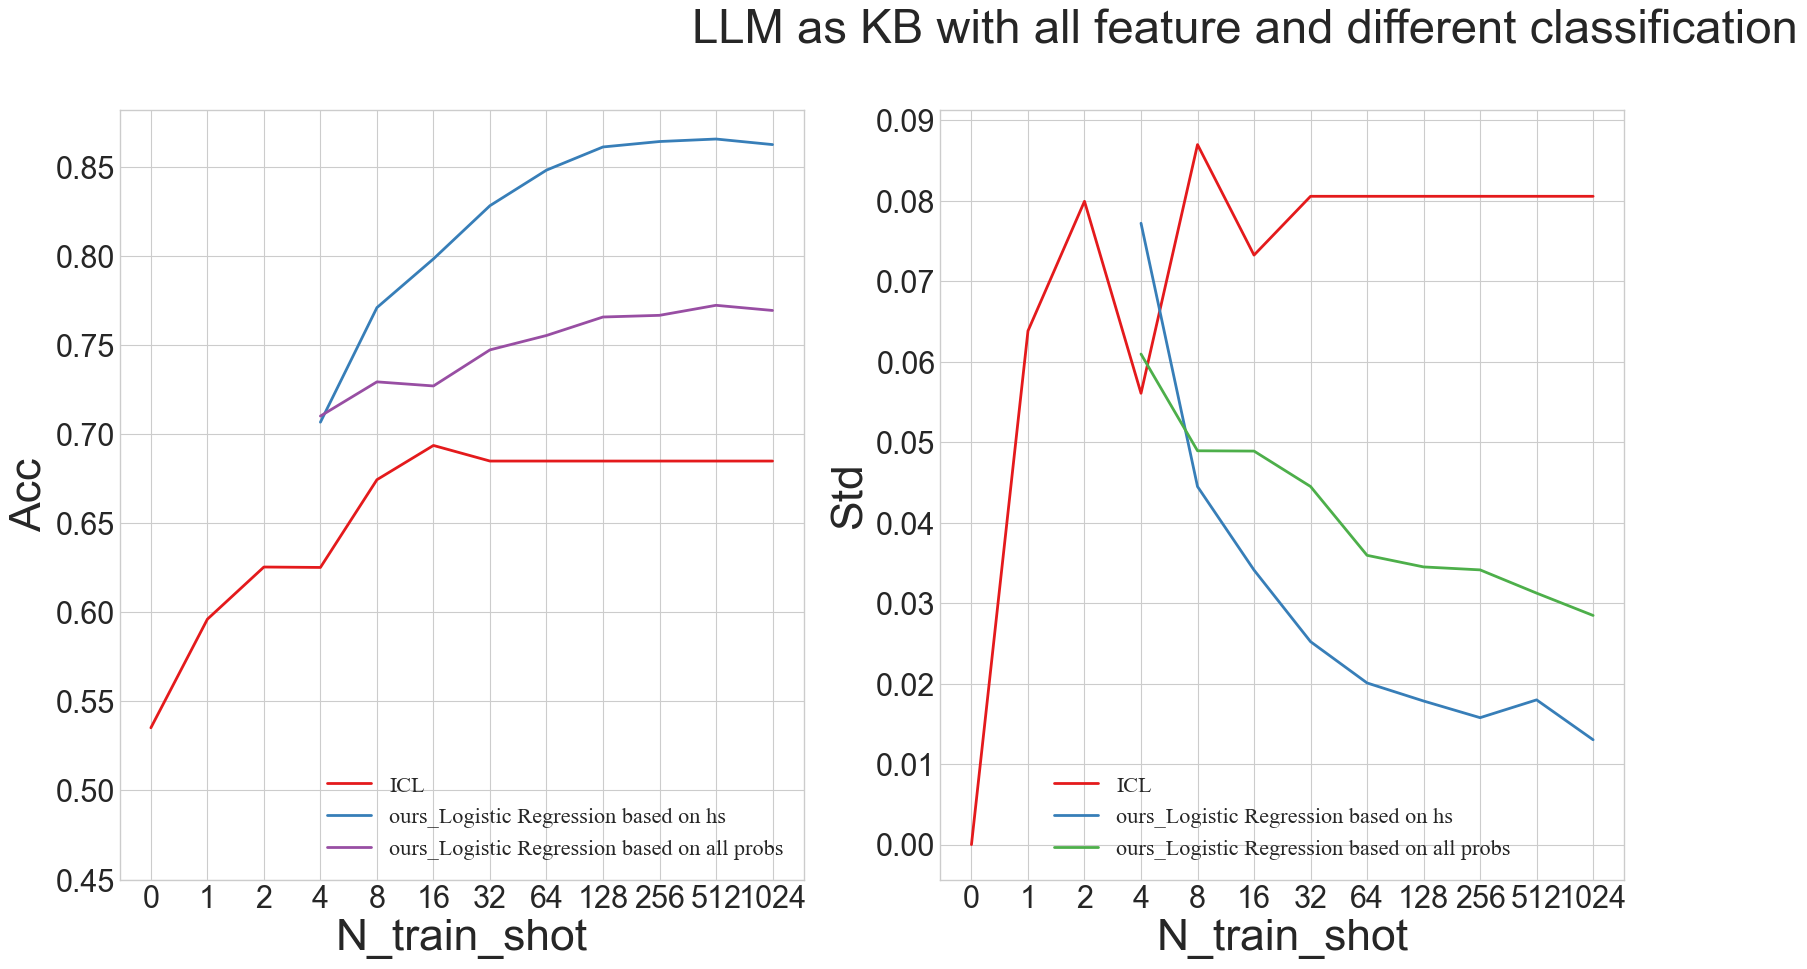

In [60]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
method_set = ['Logistic Regression', ] # 'MLP', 'Logistic Regression'
# KB results
result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
std_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
    avg_dicts.append(avg_dict)
    std_dicts.append(std_dict)

# probs with demo results
results = [f'../output/probs_all_with_demo/{MODEL}/results_KB_all_feature_{dataset}.csv' for dataset in DATASETS]
result_dfs = [pd.read_csv(result) for result in results]


avg_dicts_all_probs = []
std_dicts_all_probs = []
avg_running_time = []
for df in result_dfs:
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
            choosed_running_time = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['running_time']
    avg_dicts_all_probs.append(avg_dict)
    std_dicts_all_probs.append(std_dict)



# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)



plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}
std_dict = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts]) for method in method_set}


avg_dict_all_probs = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_all_probs]) for method in method_set}
std_dict_all_probs = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_all_probs]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)


def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours_{name_of_alg} based on hs' if not is_icl else name_of_alg,linewidth=4)

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set)*2)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg_dict_all_probs[method], color=color,label='ours_'+method + ' based on all probs',linewidth=4)



plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, std_dict[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set))
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], std_dict_all_probs[method], color=color,label='ours_'+method + ' based on all probs',linewidth=4)


plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower center',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)



plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()

#### probs with varying dims(MLP)

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\3831344447.py:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


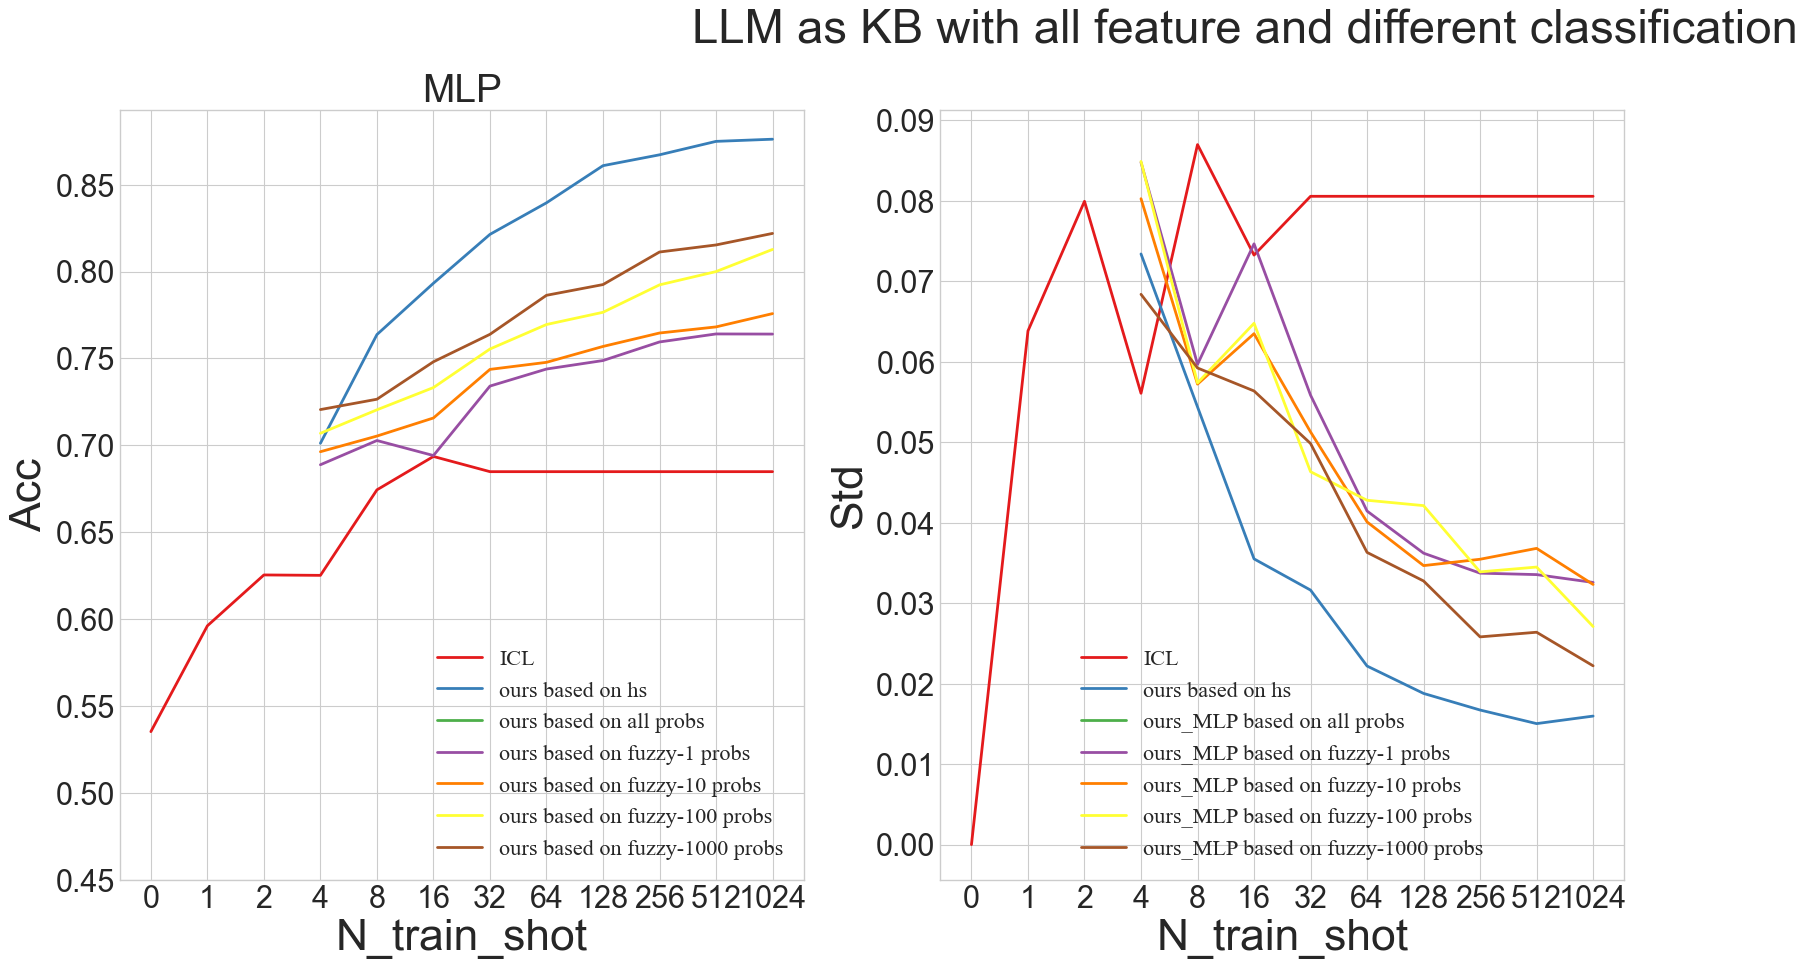

In [73]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
method_set = ['MLP',] # 'MLP', 'Logistic Regression'
# KB results
result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
std_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
    avg_dicts.append(avg_dict)
    std_dicts.append(std_dict)

# probs with demo results
results = [f'../output/probs_all_with_demo/{MODEL}/results_KB_all_feature_{dataset}.csv' for dataset in DATASETS]
result_dfs = [pd.read_csv(result) for result in results]


avg_dicts_all_probs = []
std_dicts_all_probs = []
avg_running_time = []
for df in result_dfs:
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
            choosed_running_time = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['running_time']
    avg_dicts_all_probs.append(avg_dict)
    std_dicts_all_probs.append(std_dict)

# probs with varying dims
FUZZY_K = [1, 10,100,1000]
# KB results
avg_dicts_across_k = {}
std_dicts_across_k = {}
for k in FUZZY_K:
    # if k == 1 :
    #     results = [f'../output/only_label/results_KB_only_label_feature_{dataset}.csv' for dataset in DATASETS]
    # else:
    #     results = [f'../output/fuzzy_label/results_KB_fuzzy_label_{k}_feature_{dataset}.csv' for dataset in DATASETS]
    results = [f'../output/probs_fuzzy_with_demo/{MODEL}/results_KB_fuzzy_label_{k}_feature_{dataset}.csv' for dataset in DATASETS]
    result_dfs = [pd.read_csv(result) for result in results]


    avg_dicts_k = []
    std_dicts_k = []
    # 遍历所有数据集
    for df in result_dfs:
        # method_set = df['method'].unique().tolist()
        # n_train_shot_set = df['n_train_shot'].unique().tolist()
        seed_set = df['seed'].unique().tolist()

        avg_dict = {}
        std_dict = {}
        for method in method_set:
            avg_dict[method] = []
            std_dict[method] = []
            for n_train_shot in fuzzy_label_shots:
                choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
                assert len(choosed_acc) == len(seed_set), (len(choosed_acc), len(seed_set))
                avg_dict[method].append(choosed_acc.mean())
                std_dict[method].append(choosed_acc.std())
        avg_dicts_k.append(avg_dict)
        std_dicts_k.append(std_dict)
    avg_dicts_across_k[k] = avg_dicts_k
    std_dicts_across_k[k] = std_dicts_k

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)



plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}
std_dict = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts]) for method in method_set}


avg_dict_all_probs = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_all_probs]) for method in method_set}
std_dict_all_probs = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_all_probs]) for method in method_set}

avg_dict_across_k = {}
std_dict_across_k = {}
for k in FUZZY_K:
    avg_dict_across_k[k] = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_across_k[k]]) for method in method_set}
    std_dict_across_k[k] = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_across_k[k]]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)


def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours based on hs' if not is_icl else name_of_alg,linewidth=4)

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set))
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg_dict_all_probs[method], color=color,label='ours' + ' based on all probs',linewidth=4)

for j, k in enumerate(FUZZY_K):
    for i, method in enumerate(method_set, start=1):
        choosed_shots = fuzzy_label_shots
        color=palette(i + len(method_set) * (j + 2))
        plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg_dict_across_k[k][method], color=color,label='ours' + f' based on fuzzy-{k} probs',linewidth=4)
plt.title(f"{method_set[0]}", fontsize=28)


plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, std_dict[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set))
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], std_dict_all_probs[method], color=color,label='ours_'+method + ' based on all probs',linewidth=4)

for j, k in enumerate(FUZZY_K):
    for i, method in enumerate(method_set, start=1):
        choosed_shots = fuzzy_label_shots
        color=palette(i + len(method_set) * (j + 2))
        plt.plot([all_shots.index(_shot) for _shot in choosed_shots], std_dict_across_k[k][method], color=color,label='ours_'+method + f' based on fuzzy-{k} probs',linewidth=4)



plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower center',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)



plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()

#### probs with varying dims(Logistic Regression)

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\1954275546.py:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


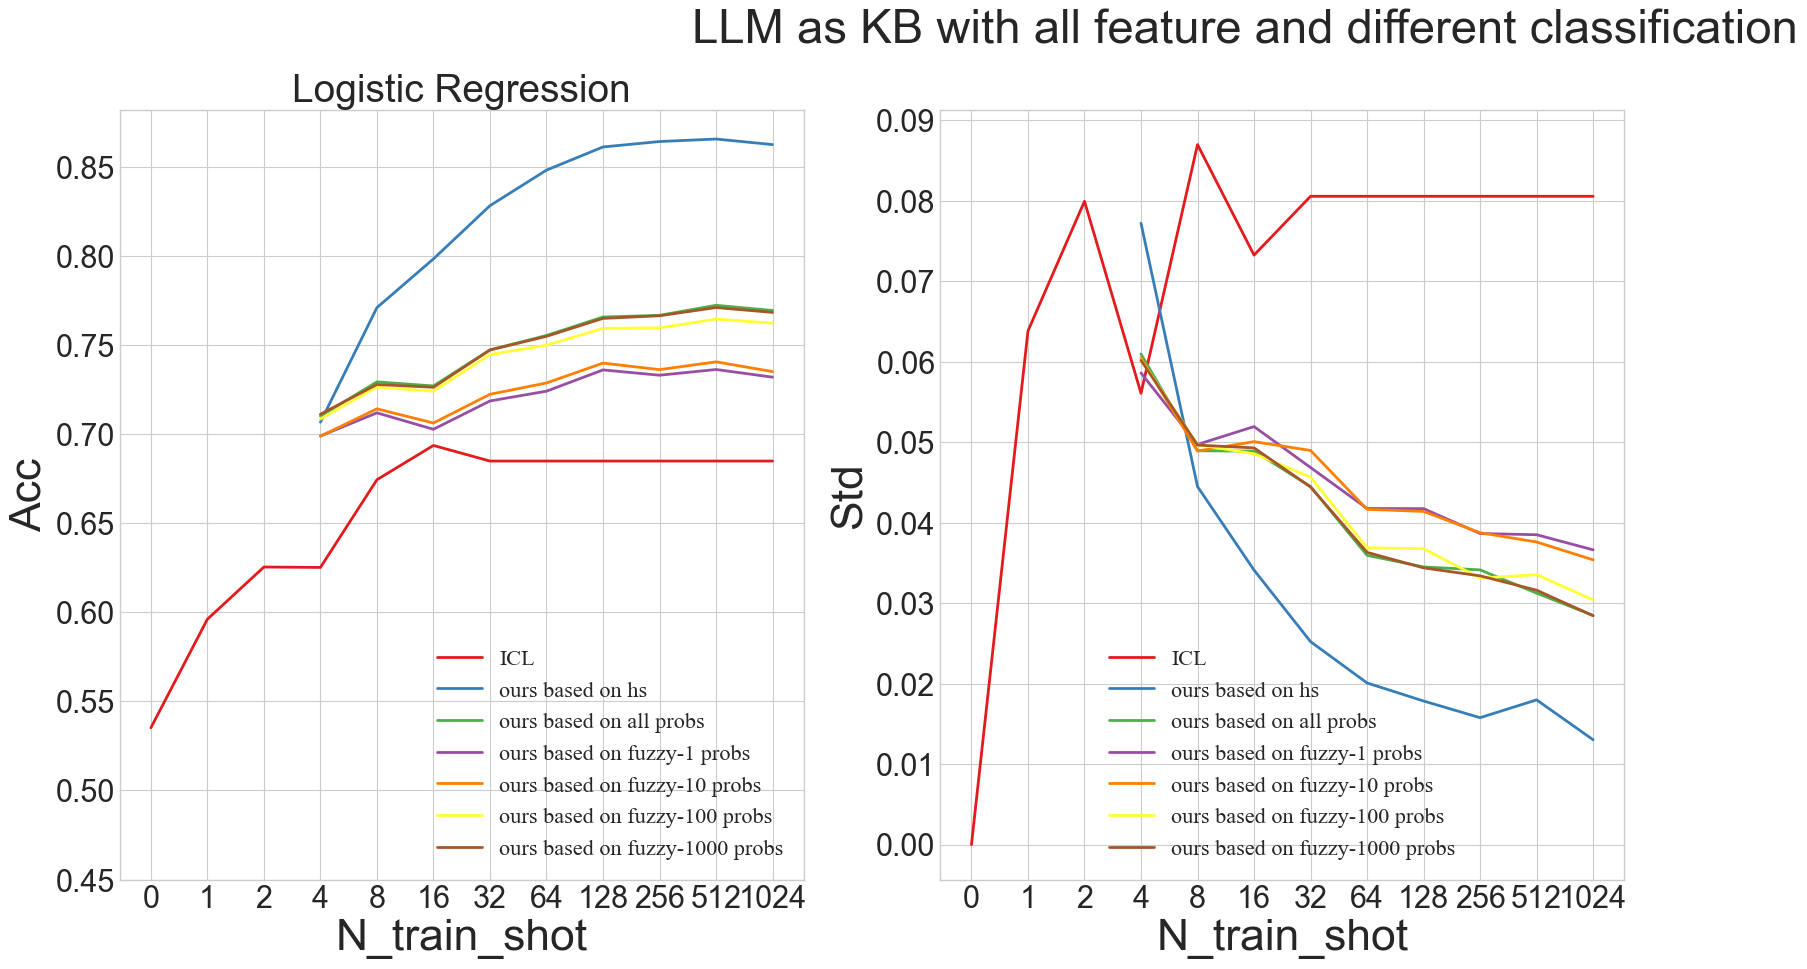

In [72]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
method_set = ['Logistic Regression',] # 'MLP', 'Logistic Regression'
# KB results
result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
std_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
    avg_dicts.append(avg_dict)
    std_dicts.append(std_dict)

# probs with demo results
results = [f'../output/probs_all_with_demo/{MODEL}/results_KB_all_feature_{dataset}.csv' for dataset in DATASETS]
result_dfs = [pd.read_csv(result) for result in results]


avg_dicts_all_probs = []
std_dicts_all_probs = []
avg_running_time = []
for df in result_dfs:
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
            choosed_running_time = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['running_time']
    avg_dicts_all_probs.append(avg_dict)
    std_dicts_all_probs.append(std_dict)

# probs with varying dims
FUZZY_K = [1, 10,100,1000]
# KB results
avg_dicts_across_k = {}
std_dicts_across_k = {}
for k in FUZZY_K:
    # if k == 1 :
    #     results = [f'../output/only_label/results_KB_only_label_feature_{dataset}.csv' for dataset in DATASETS]
    # else:
    #     results = [f'../output/fuzzy_label/results_KB_fuzzy_label_{k}_feature_{dataset}.csv' for dataset in DATASETS]
    results = [f'../output/probs_fuzzy_with_demo/{MODEL}/results_KB_fuzzy_label_{k}_feature_{dataset}.csv' for dataset in DATASETS]
    result_dfs = [pd.read_csv(result) for result in results]


    avg_dicts_k = []
    std_dicts_k = []
    # 遍历所有数据集
    for df in result_dfs:
        # method_set = df['method'].unique().tolist()
        # n_train_shot_set = df['n_train_shot'].unique().tolist()
        seed_set = df['seed'].unique().tolist()

        avg_dict = {}
        std_dict = {}
        for method in method_set:
            avg_dict[method] = []
            std_dict[method] = []
            for n_train_shot in fuzzy_label_shots:
                choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
                assert len(choosed_acc) == len(seed_set), (len(choosed_acc), len(seed_set))
                avg_dict[method].append(choosed_acc.mean())
                std_dict[method].append(choosed_acc.std())
        avg_dicts_k.append(avg_dict)
        std_dicts_k.append(std_dict)
    avg_dicts_across_k[k] = avg_dicts_k
    std_dicts_across_k[k] = std_dicts_k

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)



plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}
std_dict = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts]) for method in method_set}


avg_dict_all_probs = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_all_probs]) for method in method_set}
std_dict_all_probs = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_all_probs]) for method in method_set}

avg_dict_across_k = {}
std_dict_across_k = {}
for k in FUZZY_K:
    avg_dict_across_k[k] = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_across_k[k]]) for method in method_set}
    std_dict_across_k[k] = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts_across_k[k]]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)


def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours based on hs' if not is_icl else name_of_alg,linewidth=4)

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set))
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg_dict_all_probs[method], color=color,label='ours' + ' based on all probs',linewidth=4)

for j, k in enumerate(FUZZY_K):
    for i, method in enumerate(method_set, start=1):
        choosed_shots = fuzzy_label_shots
        color=palette(i + len(method_set) * (j + 2))
        plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg_dict_across_k[k][method], color=color,label='ours' + f' based on fuzzy-{k} probs',linewidth=4)

plt.title(f"{method_set[0]}", fontsize=28)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, std_dict[method])

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set))
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], std_dict_all_probs[method], color=color,label='ours' + ' based on all probs',linewidth=4)

for j, k in enumerate(FUZZY_K):
    for i, method in enumerate(method_set, start=1):
        choosed_shots = fuzzy_label_shots
        color=palette(i + len(method_set) * (j + 2))
        plt.plot([all_shots.index(_shot) for _shot in choosed_shots], std_dict_across_k[k][method], color=color,label='ours' + f' based on fuzzy-{k} probs',linewidth=4)



plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower center',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)



plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_9480\3806935260.py:103: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


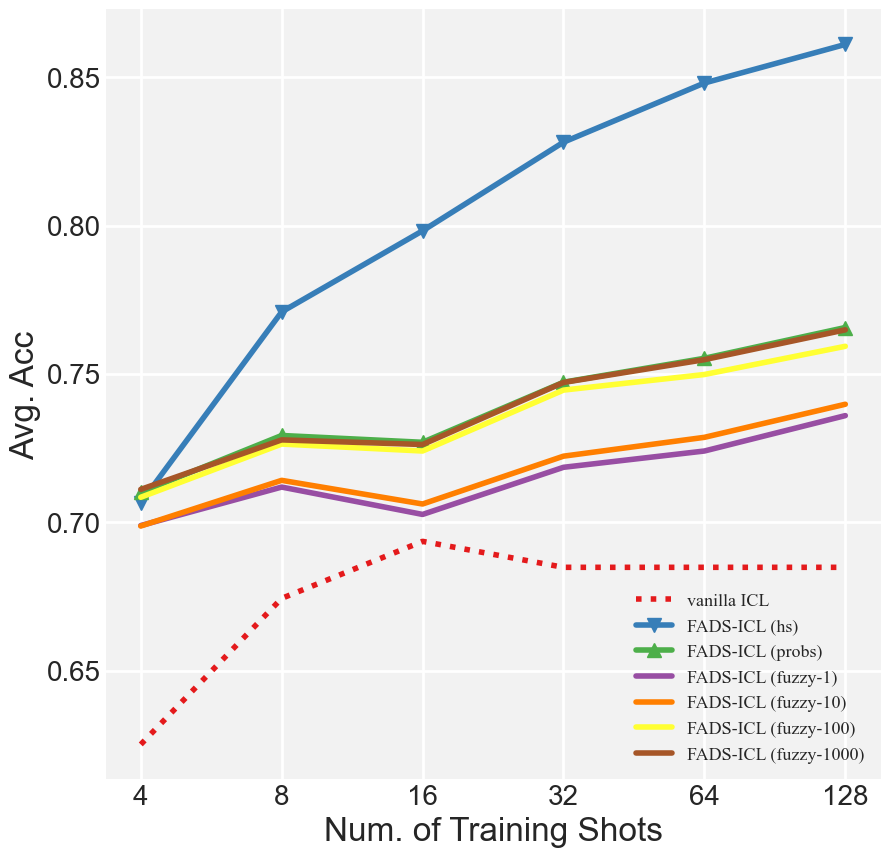

In [24]:



MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
show_shots = fuzzy_label_shots
plot_shots = [4, 8, 16, 32, 64, 128]
method_set = ['Logistic Regression',] # 'MLP', 'Logistic Regression'


# KB results
result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in plot_shots:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
    avg_dicts.append(avg_dict)

# probs with demo results
results = [f'../output/probs_all_with_demo/{MODEL}/results_KB_all_feature_{dataset}.csv' for dataset in DATASETS]
result_dfs = [pd.read_csv(result) for result in results]


avg_dicts_all_probs = []
for df in result_dfs:
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in plot_shots:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
    avg_dicts_all_probs.append(avg_dict)

# probs with varying dims
FUZZY_K = [1, 10,100,1000]
# KB results
avg_dicts_across_k = {}
for k in FUZZY_K:
    # if k == 1 :
    #     results = [f'../output/only_label/results_KB_only_label_feature_{dataset}.csv' for dataset in DATASETS]
    # else:
    #     results = [f'../output/fuzzy_label/results_KB_fuzzy_label_{k}_feature_{dataset}.csv' for dataset in DATASETS]
    results = [f'../output/probs_fuzzy_with_demo/{MODEL}/results_KB_fuzzy_label_{k}_feature_{dataset}.csv' for dataset in DATASETS]
    result_dfs = [pd.read_csv(result) for result in results]


    avg_dicts_k = []
    # 遍历所有数据集
    for df in result_dfs:
        # method_set = df['method'].unique().tolist()
        # n_train_shot_set = df['n_train_shot'].unique().tolist()
        seed_set = df['seed'].unique().tolist()

        avg_dict = {}
        for method in method_set:
            avg_dict[method] = []
            for n_train_shot in plot_shots:
                choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
                assert len(choosed_acc) == len(seed_set), (len(choosed_acc), len(seed_set))
                avg_dict[method].append(choosed_acc.mean())
        avg_dicts_k.append(avg_dict)
    avg_dicts_across_k[k] = avg_dicts_k

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_avg = icl_avg[all_shots.index(plot_shots[0]): all_shots.index(plot_shots[-1])+1]
    icl_avgs.append(icl_avg)




plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 13,
}

fig=plt.figure(figsize=(10,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}


avg_dict_all_probs = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_all_probs]) for method in method_set}

avg_dict_across_k = {}

for k in FUZZY_K:
    avg_dict_across_k[k] = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts_across_k[k]]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)


def draw_line(name_of_alg, color_index, avg, is_sicl=True,**kwargs):
    choosed_shots = plot_shots
    color=palette(color_index)
    plt.plot([plot_shots.index(_shot) for _shot in plot_shots], avg, color=color,label=f'FADS-ICL (hs)' if is_sicl else name_of_alg,linewidth=4, linestyle = 'dotted' if not is_sicl else None, **kwargs)

draw_line('vanilla ICL',0, icl_avg[- len(fuzzy_label_shots):], is_sicl=False)
# draw_line('ICL',0, icl_avg, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method],marker="v", ms=10)

for i, method in enumerate(method_set, start=1):
    choosed_shots = fuzzy_label_shots
    color=palette(i + len(method_set))
    plt.plot([plot_shots.index(_shot) for _shot in plot_shots], avg_dict_all_probs[method], color=color,label='FADS-ICL (probs)',linewidth=4,marker="^", ms=10)

for j, k in enumerate(FUZZY_K):
    for i, method in enumerate(method_set, start=1):
        choosed_shots = fuzzy_label_shots
        color=palette(i + len(method_set) * (j + 2))
        plt.plot([plot_shots.index(_shot) for _shot in plot_shots], avg_dict_across_k[k][method], color=color,label=f'FADS-ICL (fuzzy-{k})',linewidth=4)



plt.xticks(range(len(plot_shots)), labels=plot_shots,fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks(np.arange(start=0.45, stop=0.95,step=0.05), fontsize=22)
plt.xlabel('Num. of Training Shots',fontsize=24)
plt.ylabel('Avg. Acc',fontsize=24)
plt.grid(color = 'white', linestyle = '-',linewidth=2)
ax=plt.gca()  #gca:get current axis得到当前轴
ax.patch.set_facecolor("gray")
ax.patch.set_alpha(0.1) 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.show()



### vary classifiers

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\2758278423.py:104: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


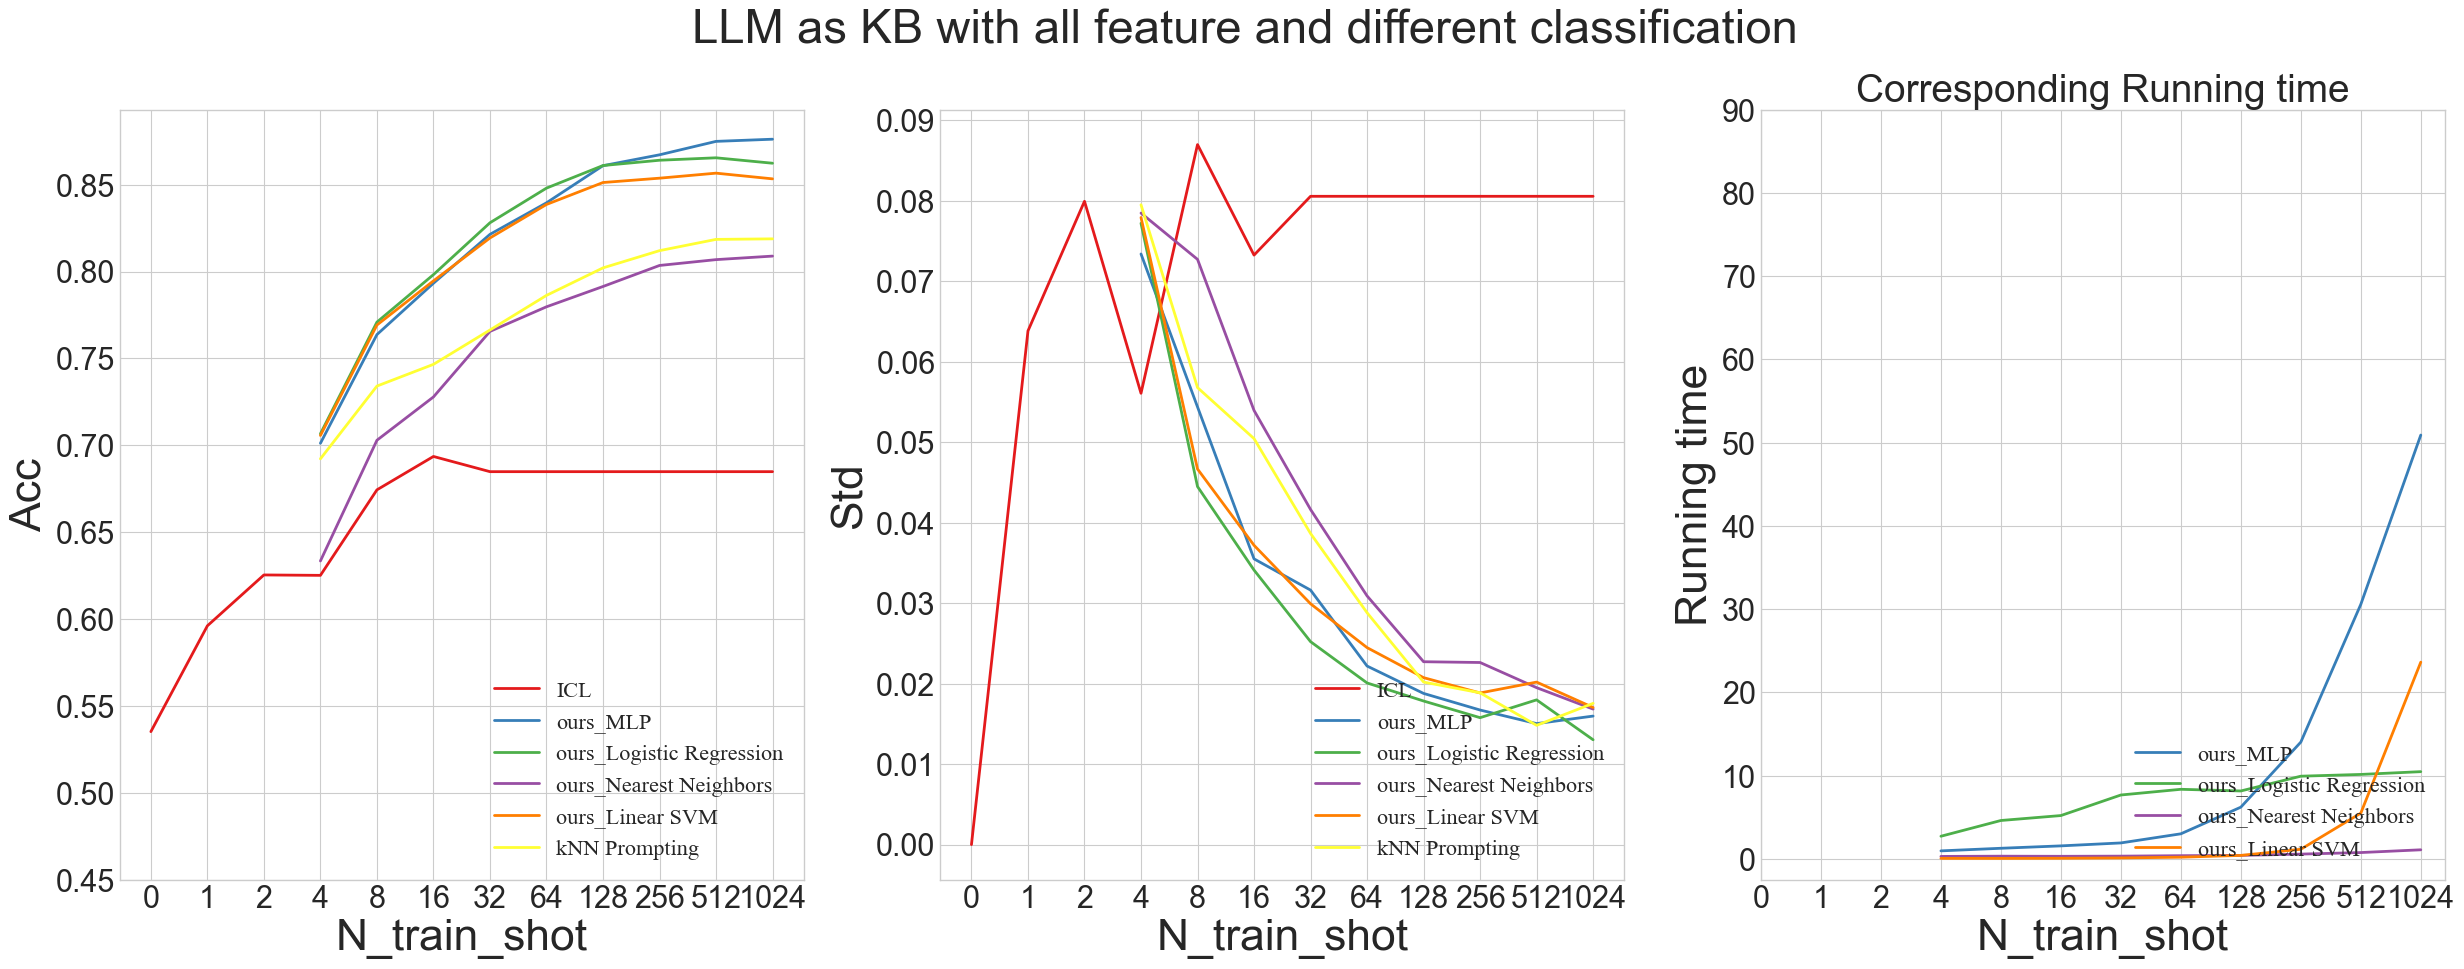

In [100]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
method_set = ['MLP', 'Logistic Regression', "Nearest Neighbors","Linear SVM",] # "Decision Tree",
# KB results
result = f'../output/ablation_other_classifiers/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
std_dicts = []
avg_running_time = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]
    # method_set = df['method'].unique().tolist()
    n_train_shot_set = df['n_train_shot'].unique().tolist()
    seed_set = df['seed'].unique().tolist()

    assert n_train_shot_set == fuzzy_label_shots

    avg_dict = {}
    std_dict = {}
    running_time_dict = {}
    for method in method_set:
        avg_dict[method] = []
        std_dict[method] = []
        running_time_dict[method] = []
        for n_train_shot in n_train_shot_set:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
            std_dict[method].append(choosed_acc.std())
            choosed_running_time = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['running_time']
            running_time_dict[method].append(choosed_running_time.mean())
    avg_dicts.append(avg_dict)
    std_dicts.append(std_dict)
    avg_running_time.append(running_time_dict)

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)

# KNN results
knn_results = '../output/results_knnprompting.csv'
knn_dfs = pd.read_csv(knn_results)

knn_avgs = []
knn_stds = []
for index, dataset in enumerate(DATASETS):
    knn_df = knn_dfs[knn_dfs['dataset'] == dataset]

    knn_avg = []
    knn_std = []
    for n_train_shot in knn_train_shots:
        choosed_acc = knn_df[knn_df['n_train_shot'] == n_train_shot]['acc']
        knn_avg.append(choosed_acc.mean())
        knn_std.append(choosed_acc.std())

    knn_avgs.append(knn_avg)
    knn_stds.append(knn_std)

# knn-prompt results
prompt_results = f'../output/knn-prompt/{MODEL}/results_knnprompt.csv'
prompt_dfs = pd.read_csv(prompt_results)

prompt_avgs = []
prompt_stds = []
for index, dataset in enumerate(DATASETS):
    prompt_df = prompt_dfs[prompt_dfs['dataset'] == dataset]

    prompt_avg = []
    prompt_std = []
    for n_train_shot in knn_train_shots:
        choosed_acc = prompt_df[prompt_df['n_train_shot'] == n_train_shot]['acc']
        prompt_avg.append(choosed_acc.mean())
        prompt_std.append(choosed_acc.std())

    prompt_avgs.append(prompt_avg)
    prompt_stds.append(prompt_std)

plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}
std_dict = {method: avg_on_dataset([_stddict[method] for _stddict in std_dicts]) for method in method_set}
running_time_dict = {method: avg_on_dataset([_timedict[method] for _timedict in avg_running_time]) for method in method_set}
icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)
def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours_{name_of_alg}' if not is_icl else name_of_alg,linewidth=4)

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, avg_dict[method])

knn_avg = avg_on_dataset(knn_avgs)
knn_std = avg_on_dataset(knn_stds)
color=palette(len(method_set) + 1)
plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_avg, color=color,label='kNN Prompting',linewidth=4)

# knn_demo1_avg = avg_on_dataset(knn_demo1_avgs)
# knn_demo1_std = avg_on_dataset(knn_demo1_stds)
# color=palette(len(method_set) + 2)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_demo1_avg, color=color,label='KNN_demo1',linewidth=4)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, std_dict[method])
color=palette(len(method_set) + 1)
plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_std, color=color,label='kNN Prompting',linewidth=4)

# color=palette(len(method_set) + 2)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_demo1_std, color=color,label='KNN_demo1',linewidth=4)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)

plt.subplot(1, 3, 3)
for i, method in enumerate(method_set, start=1):
    draw_line(method,i, running_time_dict[method])

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=100,step=10), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Running time',fontsize=32)
plt.legend(loc='lower right',prop=font1)
plt.title(f"Corresponding Running time", fontsize=28)

plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_16244\3723171582.py:78: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


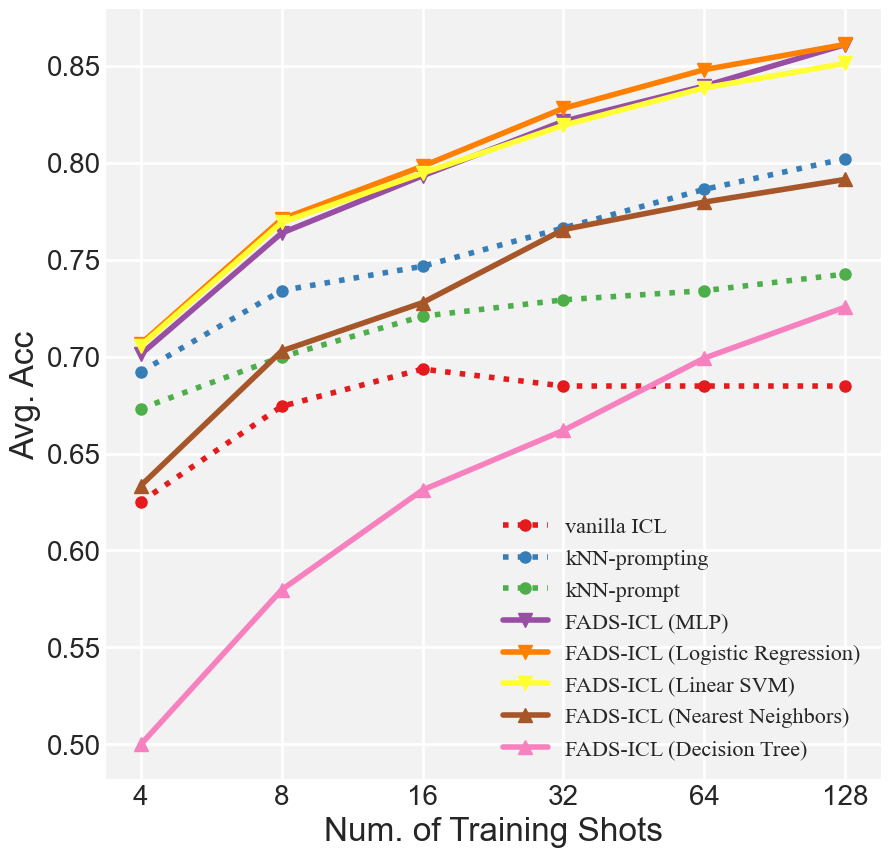

In [33]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
plot_shots = [4, 8, 16, 32, 64, 128]
method_set = ['MLP', 'Logistic Regression', "Linear SVM", "Nearest Neighbors", "Decision Tree",] # "Decision Tree",
# KB results
result = f'../output/ablation_other_classifiers/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in plot_shots:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
    avg_dicts.append(avg_dict)

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_avg = icl_avg[all_shots.index(plot_shots[0]): all_shots.index(plot_shots[-1])+1]
    icl_avgs.append(icl_avg)

# KNN results
knn_results = '../output/results_knnprompting.csv'
knn_dfs = pd.read_csv(knn_results)

knn_avgs = []
for index, dataset in enumerate(DATASETS):
    knn_df = knn_dfs[knn_dfs['dataset'] == dataset]

    knn_avg = []
    for n_train_shot in plot_shots:
        choosed_acc = knn_df[knn_df['n_train_shot'] == n_train_shot]['acc']
        knn_avg.append(choosed_acc.mean())

    knn_avgs.append(knn_avg)

# knn-prompt results
prompt_results = f'../output/knn-prompt/{MODEL}/results_knnprompt.csv'
prompt_dfs = pd.read_csv(prompt_results)

prompt_avgs = []
for index, dataset in enumerate(DATASETS):
    prompt_df = prompt_dfs[prompt_dfs['dataset'] == dataset]

    prompt_avg = []
    for n_train_shot in plot_shots:
        choosed_acc = prompt_df[prompt_df['n_train_shot'] == n_train_shot]['acc']
        prompt_avg.append(choosed_acc.mean())

    prompt_avgs.append(prompt_avg)

plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}


fig=plt.figure(figsize=(10,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)

def draw_line(name_of_alg, color_index, avg, is_sicl=True,**kwargs):
    choosed_shots = plot_shots

    color=palette(color_index)
    plt.plot([plot_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'FADS-ICL ({name_of_alg})' if is_sicl else name_of_alg,linewidth=4, linestyle = 'dotted' if not is_sicl else None, **kwargs)

draw_line('vanilla ICL',0, icl_avg[- len(fuzzy_label_shots):], is_sicl=False,marker="o", ms=8)

knn_avg = avg_on_dataset(knn_avgs)
color=palette(1)
plt.plot([plot_shots.index(_shot) for _shot in plot_shots], knn_avg, color=color,label='kNN-prompting',linewidth=4, linestyle = 'dotted',marker="o", ms=8)

prompt_avg = avg_on_dataset(prompt_avgs)
color=palette(2)
plt.plot([plot_shots.index(_shot) for _shot in plot_shots], prompt_avg, color=color,label='kNN-prompt',linewidth=4, linestyle = 'dotted',marker="o", ms=8)

for i, method in enumerate(method_set, start=3):
    if method in ['MLP', 'Logistic Regression', "Linear SVM",]:
        draw_line(method,i, avg_dict[method],marker="v", ms=10)
    else:
        draw_line(method,i, avg_dict[method],marker="^", ms=10)



plt.xticks(range(len(plot_shots)), labels=plot_shots,fontsize=20)
plt.yticks( fontsize=20)
# plt.yticks(np.arange(start=0.45, stop=0.95,step=0.05), fontsize=22)
plt.xlabel('Num. of Training Shots',fontsize=24)
plt.ylabel('Avg. Acc',fontsize=24)
plt.grid(color = 'white', linestyle = '-',linewidth=2)
ax=plt.gca()  #gca:get current axis得到当前轴
ax.patch.set_facecolor("gray")
ax.patch.set_alpha(0.1) 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.show()

#### intro (plot)

C:\Users\USER\AppData\Local\Temp\ipykernel_16244\857450214.py:64: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


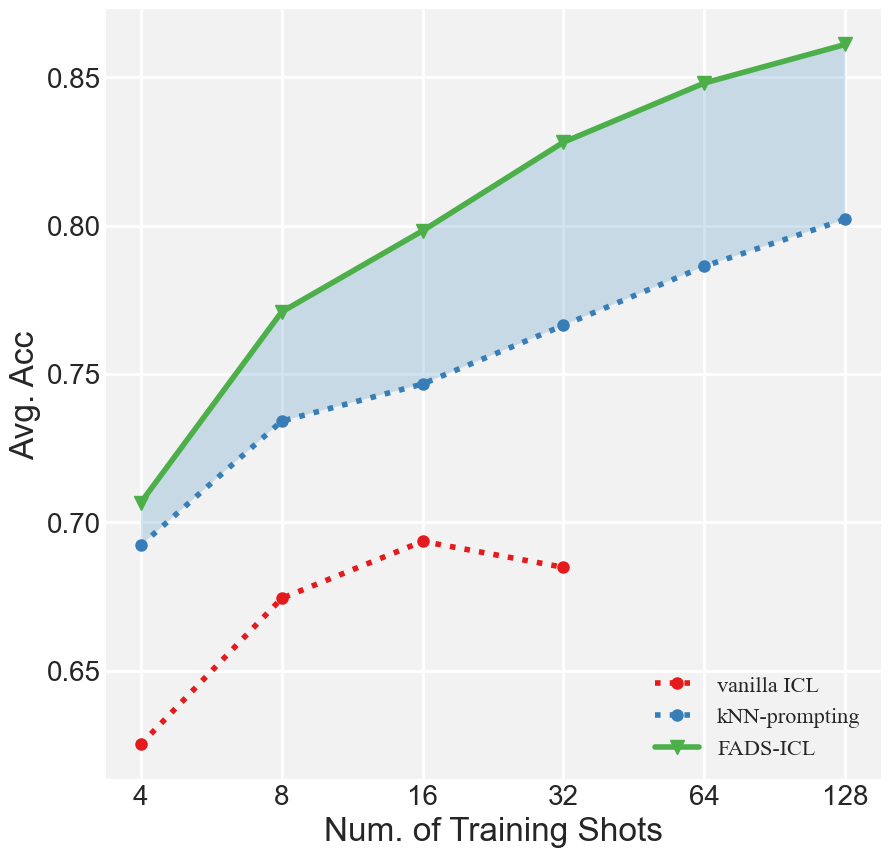

In [35]:
MODEL='gpt2-xl'
DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots
plot_shots = [4, 8, 16, 32, 64, 128]
method_set = [ 'Logistic Regression'] # "Decision Tree",
# KB results
result = f'../output/ablation_other_classifiers/{MODEL}/results_hs_as_feature.csv'
result_dfs = pd.read_csv(result)


avg_dicts = []
for dataset in DATASETS:
    df = result_dfs[result_dfs['dataset']==dataset]

    avg_dict = {}
    for method in method_set:
        avg_dict[method] = []
        for n_train_shot in plot_shots:
            choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
            avg_dict[method].append(choosed_acc.mean())
    avg_dicts.append(avg_dict)

# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_avg = icl_avg[all_shots.index(plot_shots[0]): all_shots.index(plot_shots[-1])+1]
    icl_avgs.append(icl_avg)

# KNN results
knn_results = '../output/results_knnprompting.csv'
knn_dfs = pd.read_csv(knn_results)

knn_avgs = []
for index, dataset in enumerate(DATASETS):
    knn_df = knn_dfs[knn_dfs['dataset'] == dataset]

    knn_avg = []
    for n_train_shot in plot_shots:
        choosed_acc = knn_df[knn_df['n_train_shot'] == n_train_shot]['acc']
        knn_avg.append(choosed_acc.mean())

    knn_avgs.append(knn_avg)


plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}


fig=plt.figure(figsize=(10,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
avg_dict = {method: avg_on_dataset([_avgdict[method] for _avgdict in avg_dicts]) for method in method_set}

icl_avg = avg_on_dataset(icl_avgs)
plot_icl_shots = [4,8,16,32]

def draw_line(name_of_alg, color_index, avg, is_sicl=True, is_icl=False,**kwargs):
    choosed_shots = plot_shots if not is_icl else plot_icl_shots

    color=palette(color_index)
    plt.plot([plot_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'FADS-ICL' if is_sicl else name_of_alg,linewidth=4, linestyle = 'dotted' if not is_sicl else None,**kwargs)


draw_line('vanilla ICL',0, icl_avg[- len(fuzzy_label_shots):][: len(plot_icl_shots)], is_sicl=False, is_icl=True,marker="o", ms=8)

knn_avg = avg_on_dataset(knn_avgs)
color=palette(1)
plt.plot([plot_shots.index(_shot) for _shot in plot_shots], knn_avg, color=color,label='kNN-prompting',linewidth=4, linestyle = 'dotted',marker="o", ms=8)


for i, method in enumerate(method_set, start=2):
    draw_line(method,i, avg_dict[method],marker="v", ms=10)

plt.fill_between([plot_shots.index(_shot) for _shot in plot_shots], knn_avg,  avg_dict[method_set[0]],\
                 alpha=0.2,)



plt.xticks(range(len(plot_shots)), labels=plot_shots,fontsize=20)
plt.yticks( fontsize=20)
# plt.yticks(np.arange(start=0.45, stop=0.95,step=0.05), fontsize=22)
plt.xlabel('Num. of Training Shots',fontsize=24)
plt.ylabel('Avg. Acc',fontsize=24)
plt.grid(color = 'white', linestyle = '-',linewidth=2)
ax=plt.gca()  #gca:get current axis得到当前轴
ax.patch.set_facecolor("gray")
ax.patch.set_alpha(0.1) 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.show()

### vary scales of LLM

C:\Users\USER\AppData\Local\Temp\ipykernel_20656\445337917.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


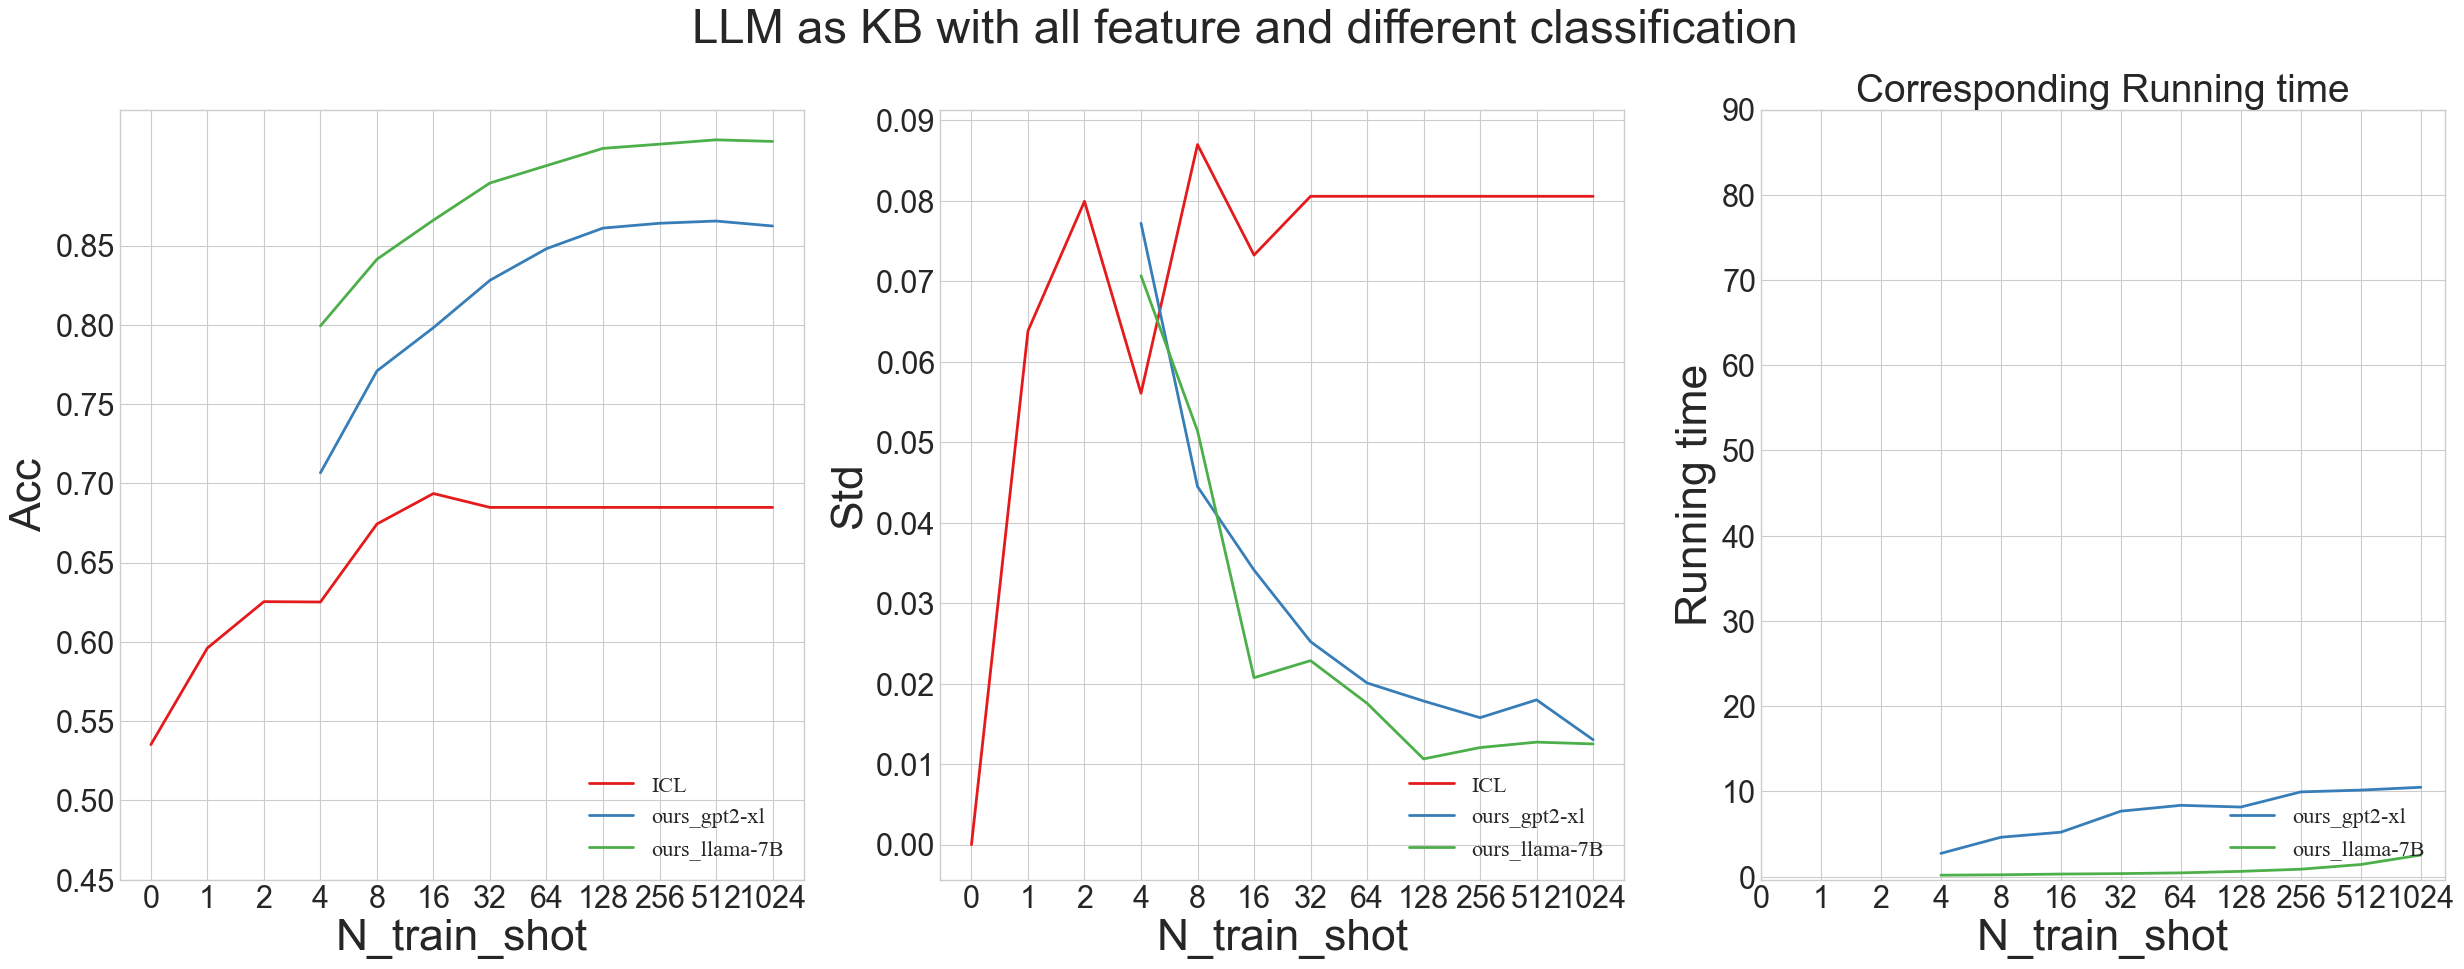

In [82]:

DATASETS = ['sst2', 'subj', 'mpqa', 'agnews', 'cb', 'cr', 'dbpedia', 'mr', 'rte', 'trec']
MAX_ICL_SHOTS = [16, 8, 32, 2, 2, 8, 1, 8, 4, 8]
all_shots = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fuzzy_label_shots = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
knn_train_shots = fuzzy_label_shots


# icl results
icl_results = [f'../output/icl/results_icl_{dataset}.csv' for dataset in DATASETS]
icl_dfs = [pd.read_csv(icl_result) for icl_result in icl_results]

icl_avgs = []
icl_stds = []
for index, icl_df in enumerate(icl_dfs):
    icl_n_train_shot_set = icl_df['n_train_shot'].unique().tolist()

    assert icl_n_train_shot_set == all_shots[:len(icl_n_train_shot_set)]

    icl_avg = []
    icl_std = []
    for n_train_shot in icl_n_train_shot_set:
        choosed_acc = icl_df[icl_df['n_train_shot'] == n_train_shot]['acc']
        icl_avg.append(choosed_acc.mean())
        icl_std.append(choosed_acc.std())

    # adjust icl result
    remain_num = len(icl_n_train_shot_set)
    icl_avg = icl_avg + [icl_avg[- 1]]*(len(all_shots) - remain_num)
    icl_std = icl_std + [icl_std[- 1]]*(len(all_shots) - remain_num)
    icl_avgs.append(icl_avg)
    icl_stds.append(icl_std)

plt.style.use('seaborn-whitegrid')
palette = plt.get_cmap('Set1')
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig=plt.figure(figsize=(30,10))

def avg_on_dataset(metrics_list):
    return np.array(metrics_list).mean(axis=0)
icl_avg = avg_on_dataset(icl_avgs)
icl_std = avg_on_dataset(icl_stds)
def draw_line(name_of_alg, color_index, avg, is_icl=False):
    if not is_icl:
        choosed_shots = fuzzy_label_shots
    else:
        choosed_shots = all_shots
    color=palette(color_index)
    plt.plot([all_shots.index(_shot) for _shot in choosed_shots], avg, color=color,label=f'ours_{name_of_alg}' if not is_icl else name_of_alg,linewidth=4)



MODELS = ['gpt2-xl', 'llama-7B']
avg_dict_model = {}
std_dict_model = {}
running_time_dict_model = {}
for j, MODEL in enumerate(MODELS):
    method_set = ['Logistic Regression'] # "Decision Tree",
    # KB results
    result = f'../output/hs_as_feature_with_demo/{MODEL}/results_hs_as_feature.csv'
    result_dfs = pd.read_csv(result)


    avg_dicts = []
    std_dicts = []
    avg_running_time = []
    for dataset in DATASETS:
        df = result_dfs[result_dfs['dataset']==dataset]
        # method_set = df['method'].unique().tolist()
        n_train_shot_set = df['n_train_shot'].unique().tolist()
        seed_set = df['seed'].unique().tolist()

        assert n_train_shot_set == fuzzy_label_shots

        avg_dict = {}
        std_dict = {}
        running_time_dict = {}
        for method in method_set:
            avg_dict[method] = []
            std_dict[method] = []
            running_time_dict[method] = []
            for n_train_shot in n_train_shot_set:
                choosed_acc = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['acc']
                avg_dict[method].append(choosed_acc.mean())
                std_dict[method].append(choosed_acc.std())
                choosed_running_time = df[(df['method'] == method) & (df['n_train_shot'] == n_train_shot)]['running_time']
                running_time_dict[method].append(choosed_running_time.mean())
        avg_dicts.append(avg_dict)
        std_dicts.append(std_dict)
        avg_running_time.append(running_time_dict)

    avg_dict_model[MODEL] =  avg_on_dataset([_avgdict[method_set[0]] for _avgdict in avg_dicts])
    std_dict_model[MODEL] = avg_on_dataset([_stddict[method_set[0]] for _stddict in std_dicts])
    running_time_dict_model[MODEL] = avg_on_dataset([_timedict[method_set[0]] for _timedict in avg_running_time])

plt.subplot(1, 3, 1)
draw_line('ICL',0, icl_avg, is_icl=True)

for i, MODEL in enumerate(MODELS, start=1):
    draw_line(MODEL,i, avg_dict_model[MODEL])

# knn_avg = avg_on_dataset(knn_avgs)
# knn_std = avg_on_dataset(knn_stds)
# color=palette(len(method_set) + 1)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_avg, color=color,label='kNN Prompting',linewidth=4)

# knn_demo1_avg = avg_on_dataset(knn_demo1_avgs)
# knn_demo1_std = avg_on_dataset(knn_demo1_stds)
# color=palette(len(method_set) + 2)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_demo1_avg, color=color,label='KNN_demo1',linewidth=4)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0.45, stop=0.9,step=0.05), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Acc',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"fuzzy label with all features for each label", fontsize=28)

plt.subplot(1, 3, 2)
draw_line('ICL',0, icl_std, is_icl=True)
for i, MODEL in enumerate(MODELS, start=1):
    draw_line(MODEL,i, std_dict_model[MODEL])
# color=palette(len(method_set) + 1)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_std, color=color,label='kNN Prompting',linewidth=4)

# color=palette(len(method_set) + 2)
# plt.plot([all_shots.index(_shot) for _shot in knn_train_shots], knn_demo1_std, color=color,label='KNN_demo1',linewidth=4)

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=0.1,step=0.01), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Std',fontsize=32)
plt.legend(loc='lower right',prop=font1)
# plt.title(f"Corresponding Std", fontsize=28)

plt.subplot(1, 3, 3)
for i, MODEL in enumerate(MODELS, start=1):
    draw_line(MODEL,i, running_time_dict_model[MODEL])

plt.xticks(range(len(all_shots)), labels=all_shots,fontsize=22)
plt.yticks(np.arange(start=0, stop=100,step=10), fontsize=22)
plt.xlabel('N_train_shot',fontsize=32)
plt.ylabel('Running time',fontsize=32)
plt.legend(loc='lower right',prop=font1)
plt.title(f"Corresponding Running time", fontsize=28)

plt.suptitle("LLM as KB with all feature and different classification",fontsize=34)
plt.show()